# Estimate the uncertainties from repeats

## Author(s): Sven Buder (SB, WG4)

### History:
190215 SB Created

In [23]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import collections
import glob
import scipy
import scipy.optimize
import pickle
import pandas
import time
import itertools

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table, hstack, vstack, join
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

In [24]:
data_idr3       = Table.read('../data_products/GALAH_iDR3_combined_10k.fits',1)
data_abund_idr3 = Table.read('../data_products/GALAH_iDR3_combined_10k_abund.fits',1)
data_in = join(data_idr3, data_abund_idr3)

In [25]:
# # cut out all the stars that do not fulfill the quality criterion (including those with NaN values)
# quality_flag = 0
# quality_cut = (data_in['flag_sp'] <= quality_flag)
# data = data_in[quality_cut]

print('NOT USING JOINED TABLE')
# cut out all the stars that do not fulfill the quality criterion (including those with NaN values)
quality_flag = 0
quality_cut = (data_idr3['flag_sp'] <= quality_flag)
data = data_idr3[quality_cut]

NOT USING JOINED TABLE


In [26]:
class Plm2(object):
    """
    Uses object-oriented matplotlib 
    fig,axes=plt.subplot(rows,cols)    
    plm.ax is the current axis
    For sutil.hist_nd.imshow, you have to get back a mappable image object
    and pass it on to colorbar after tight_layout
    plm=putil.Plm2(2,2); 
    for in range(2):
        plm.next()
        im1=h.imshow(,ax=plm.ax)
        plm.next()
        im2=h.imshow(,ax=plm.ax)
    plm.tight_layout()
    For single colorbar on side
    plt.colorbar(im2,ax=plm.axes,location='right')
    For two colorbars on top
    plt.colorbar(im1,ax=plm.axes[:,0],location='top',pad=0,fraction=0.08,use_gridspec=False)
    plt.colorbar(im2,ax=plm.axes[:,1],location='top',pad=0,fraction=0.08)
    For two colorbars on right 
    plt.colorbar(im1,ax=plm.axes[0,:],location='right')
    plt.colorbar(im2,ax=plm.axes[1,:],location='right')

    """
    def __init__(self,rows=1,cols=1,xsize=7.0,ysize=7.0,xmulti=False,ymulti=False,full=False,slabelx=0.89,slabely=0.1,slabel=True,order='left-right',aspect=None):
        self.slabels=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','aa','ab','ac','ad','ae','af','ag','ah','ai','aj','ak','al','am','an','ao','ap','aq','ar','as','at','au','av','aw','ax','ay','az']
        params = {'font.size':12,
                  'text.usetex':False,
                  'ytick.labelsize': 'medium',
                  'legend.fontsize': 'large',
                  'axes.linewidth': 1.0,
                  'xtick.labelsize': 'medium',
                  'font.family': 'sans-serif',
                  'axes.labelsize': 'medium'}
        plt.rcParams.update(params)

        # if xsize>13.0:
        #     mpl.rcParams['font.size']=15
        #     mpl.rcParams['legend.fontsize']=15
        #mpl.rcParams['text.usetex'] = True
        if full:
            #mpl.rcParams['axes.titlesize']=8
            plt.rcParams['font.size']=8
            plt.rcParams['legend.fontsize']=8
        else: 
            plt.rcParams['font.size']=15
            plt.rcParams['legend.fontsize']=15

        self.rows=rows
        self.cols=cols
        self.figno=0
        self.panelno=0
        self.xmulti=xmulti
        self.ymulti=ymulti
        self.slabelx=slabelx
        self.slabely=slabely
        self.slabel=slabel
        self.order=order
        if aspect=='equal':
            self.fig,self.axes=plt.subplots(self.rows,self.cols,figsize=(xsize,ysize))
            for ax in self.axes.flat:
                ax.set_aspect('equal')            
        else:
            self.fig,self.axes=plt.subplots(self.rows,self.cols,figsize=(xsize,ysize))

        if type(self.axes) == np.ndarray:
            self.image=self.axes.flat[self.panelno-1]
        else:
            self.ax=self.axes


    def panels(self):
        return self.rows*self.cols

    def next(self):        
        self.figno+=1
        self.figno=(self.figno-1) % (self.rows*self.cols)+1
        if type(self.order) == list:
            self.panelno=self.order[self.figno-1]
        else:
            if self.order == 'top-down':
                r=(self.figno-1)//self.rows
                c=(self.figno-1)%self.rows
                self.panelno=(c*self.cols+r)+1
            else:
                self.panelno=self.figno
        if type(self.axes) == np.ndarray:
            self.ax=self.axes.flat[self.panelno-1]
        else:
            self.ax=self.axes
        plt.sca(self.ax)
        self.ax.tick_params(axis='both',which='both',direction='in')
#        self.ax.tick_params(axis='both',which='minor',bottom='on')
        self.lcount=0
        if (self.slabel) and (self.rows*self.cols > 1):
            self.ax.text(self.slabelx,self.slabely,'('+self.slabels[(self.panelno-1)%len(self.slabels)]+')',transform=self.ax.transAxes)

        if self.xmulti:
            if (self.panelno-1)//self.cols != (self.rows-1):
                self.ax.set_xticklabels('')
                #ax.set_xticks([])
        if self.ymulti:
            if (self.panelno-1) % self.cols != 0:
                self.ax.set_yticklabels('')
                #ax.set_yticks([])
        self.ax.yaxis.set_ticks_position('both')
        self.ax.xaxis.set_ticks_position('both')

    def xlabel(self,s,fontsize=20):        
        if self.xmulti:
            if (self.panelno-1)//self.cols == (self.rows-1):
                self.ax.set_xlabel(s, fontsize=fontsize)
        else:
            self.ax.set_xlabel(s, fontsize=fontsize)

    def ylabel(self,s,fontsize=20):        
        if self.ymulti:
            if (self.panelno-1) % self.cols == 0:
                self.ax.set_ylabel(s, fontsize=fontsize)
        else:
            self.ax.set_ylabel(s, fontsize=fontsize)

    # def colorbar(self,mode='single',location='right',*args,**kwargs):
    #     if mode
    #     for self.axes.shape[1]:
    #         self.fig.colorbar(*args,ax=self.axes[:,0],pad=0.0,**kwargs)
    #     self.fig.colorbar(*args,ax=self.ax,pad=0.0,**kwargs)
    #     self.fig.colorbar(*args,ax=self.axes,pad=0.0,**kwargs)
    #     self.fig.colorbar(*args,ax=self.axes[:,0],pad=0.0,**kwargs)
        #self.fig.colorbar(*args,ax=self.ax,fraction=0.1,pad=0.0,**kwargs)

    # def figcolorbar(self,*args,**kwargs):
    #     self.fig.colorbar(*args,ax=self.axes,**kwargs)

    def colorbar(self,*args,**kwargs):
        cbar=plt.colorbar(*args,**kwargs)
        # if self.xmulti:
        #     if (self.panelno-1)//self.cols != 0:
        #         cbar.ax.xaxis.set_major_locator(plt.NullLocator())
        #         cbar.ax.set_xticklabels('')
        if self.ymulti:
            if (self.panelno-1) % self.cols != (self.cols-1):
                cbar.ax.yaxis.set_major_locator(plt.NullLocator())
                cbar.ax.set_yticklabels('')

    def get_mappable(self,axes):
        if len(axes.images) > 0:
            return axes.images[0]
        else:
            return axes.collections[0]
            

    def colorbarx(self,irow,icol,aspect=20.0,location='top',single=False,adjust=False,**kwargs):
        if (hasattr(self.axes,"__len__") == False):
            image=self.get_mappable(self.axes)
            win=self.axes.get_window_extent().get_points()/(self.fig.dpi)
            win2=self.axes.get_window_extent().get_points()/(self.fig.dpi)
        else:
            if self.axes.ndim ==1:
                image=self.get_mappable(self.axes[irow])
                win=self.axes[icol].get_window_extent().get_points()/(self.fig.dpi)
                win2=self.axes[icol].get_window_extent().get_points()/(self.fig.dpi)
            else:
                image=self.get_mappable(self.axes[irow,icol])
                win=self.axes[0,icol].get_window_extent().get_points()/(self.fig.dpi)
                win2=self.axes[-1,icol].get_window_extent().get_points()/(self.fig.dpi)
        if location == 'top':
            frac=((win[1,0]-win[0,0])/aspect+2.5*(mpl.rcParams['font.size'])*(1/72.0))/(win[1,1]-win2[0,1])
            if single:
                cbar=plt.colorbar(image,ax=self.axes,location='top',use_gridspec=False,pad=0.02,fraction=frac,aspect=aspect,**kwargs)
            else:
                if self.axes.ndim ==1:
                    cbar=plt.colorbar(image,ax=self.axes[icol],location='top',use_gridspec=False,pad=0.0,fraction=frac,aspect=aspect,**kwargs)
                else:
                    cbar=plt.colorbar(image,ax=self.axes[:,icol],location='top',use_gridspec=False,pad=0.0,fraction=frac,aspect=aspect,**kwargs)
                if adjust:
                    win=self.axes[0,icol].get_window_extent().get_points()/(self.fig.dpi)
                    plt.subplots_adjust(top=win[1,1]/self.fig.get_size_inches()[1])
        else:
            if single:
                cbar=plt.colorbar(image,ax=self.axes,location='right',pad=0.02,use_gridspec=False,aspect=aspect,**kwargs)
            else:
                if self.axes.ndim ==1:
                    cbar=plt.colorbar(image,ax=self.axes[irow],location='right',use_gridspec=False,pad=0.0,aspect=aspect,**kwargs)
                else:
                    cbar=plt.colorbar(image,ax=self.axes[irow,:],location='right',use_gridspec=False,pad=0.0,aspect=aspect,**kwargs)
        return cbar
    # def colorbar_single_right(self,irow,icol,adjust=True,aspect=20.0,**kwargs):
    #     win=self.axes[0,icol].get_window_extent().get_points()/(self.fig.dpi)
    #     win2=self.axes[-1,icol].get_window_extent().get_points()/(self.fig.dpi)
    #     frac=((win[1,0]-win[0,0])/aspect+3.5*(mpl.rcParams['font.size'])*(1/72.0))/(win[1,1]-win2[0,1])
    #     cbar=plt.colorbar(self.axes[irow,icol].images[0],ax=self.axes,location='top',use_gridspec=False,pad=0.02,fraction=frac,aspect=aspect,**kwargs)
    #     if adjust:
    #         win=self.axes[0,icol].get_window_extent().get_points()/(self.fig.dpi)
    #         plt.subplots_adjust(top=win[1,1]/self.fig.get_size_inches()[1])

    def tight_layout(self,wspace=0.0,hspace=0.0):
        if (self.ymulti or self.xmulti):
            for ax in self.axes.flat:
                if (self.xmulti):                    
                    ax.yaxis.set_major_locator(MaxNLocator('auto',prune='upper'))
                    if ax.get_yscale()  ==  'log':
                        ax.set_yscale('log')
                if (self.ymulti):
                    ax.xaxis.set_major_locator(MaxNLocator('auto',prune='upper'))
                    if ax.get_xscale()  ==  'log':
                        ax.set_xscale('log')
        self.fig.tight_layout()
        if (self.ymulti and self.xmulti):
            self.fig.subplots_adjust(wspace=wspace,hspace=hspace)
        elif self.ymulti and (self.xmulti==False):
            self.fig.subplots_adjust(wspace=wspace)
        elif self.xmulti and (self.ymulti==False):
            self.fig.subplots_adjust(hspace=hspace)
        # for ax in self.axes.flat:
        #     plt.setp(ax.get_yticklabels()[-1],visible=False)
        #     plt.setp(ax.get_xticklabels()[-1],visible=False)



    def xoffset(self):
        ax=self.ax
        ax.set_xlabel('{0} {1}'.format(ax.get_xlabel(), ax.get_xaxis().get_offset_text().get_text()))
        ax.get_xaxis().get_offset_text().set_visible(False)


    def yoffset(self):
        ax=self.ax
        offset = ax.get_yaxis().get_offset_text()
        ax.set_ylabel('{0} {1}'.format(ax.get_ylabel(), offset.get_text()))
        offset.set_visible(False)

    def text(self,x,y,label, **kwargs):
        self.ax.text(x,y,label,transform=self.ax.transAxes,**kwargs)

    def legend(self,ncol=1, **kwargs):
        # matplotlib has a ppi (points per pinch) of 72.
        l=self.fig.legend(bbox_to_anchor=(0.5,1),loc='upper center',bbox_transform=self.fig.transFigure,ncol=ncol,frameon=False, **kwargs)
        #f=3*(mpl.rcParams['font.size'])*(1/72.0)/self.fig.get_size_inches()[1]
        self.fig.canvas.draw()
        y0=l.get_window_extent().get_points()[0,1]/(self.fig.dpi*self.fig.get_size_inches()[1])
        f=0.5*(plt.rcParams['font.size'])*(1/72.0)/self.fig.get_size_inches()[1]
        self.fig.subplots_adjust(top=y0-f)

In [27]:
def percentile(values, quantiles, weights=None):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 100]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param weights: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    if weights is None:
        return np.nanpercentile(values,quantiles)
#        weights = np.ones(len(values))
    values = np.array(values)
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)
    cond=np.isfinite(values)    
    values=values[cond]
    weights=weights[cond]

    quantiles = np.array(quantiles)/100.0
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    ind = np.argsort(values)
    values = values[ind]
    weights = weights[ind]

    weighted_quantiles = np.cumsum(weights) - 0.5 * weights
    # if consistent with numpy.percentile 
    #if old_style:
    weighted_quantiles -= weighted_quantiles[0]
    weighted_quantiles /= weighted_quantiles[-1]
    #else: 
    #    weighted_quantiles /= np.sum(weights)
    return np.interp(quantiles, weighted_quantiles, values)

In [28]:
def profile(x,z,bins=100,range=None,label=None,mincount=3,fmt='-o',color='',meanerror=False,style=None,func=None,lw=None,return_profile=False,ms=None,error=None,weights=None,alpha=1):
    """
    style: ['lines','fill_between,'errorbar']
    func: default is np.median
    """
    
    #style=['lines','fill_between','errorbar']
    ind=np.where(np.isfinite(x)&np.isfinite(z))[0]
    x=x[ind]
    z=z[ind]
    if weights is None:
        w=None
    else:
        w=weights[ind]
    h=hist_nd(x,bins=bins,range=range)
    ind1=np.where(h.data>=mincount)[0]
    if func is None:
        ym=h.apply(z,percentile,50.0,weights=weights)
        # if weights is None:
        #     ym=h.apply(z,np.median)
        # else:
        #     ym=h.apply_quantile_1D(z,w,0.5)
    else:
        ym=h.apply(z,func,weights=weights)
    xm=h.locations[0]

    yl=h.apply(z,percentile,16,weights=weights)
    yh=h.apply(z,percentile,84,weights=weights)

    if error is not None:
        yl=ym-h.apply(error,percentile,50,weights=weights)
        yh=ym+h.apply(error,percentile,50,weights=weights)

        
    if meanerror:
        if weights is None:
            yl=ym+(yl-ym)/np.sqrt(h.data)
            yh=ym+(yh-ym)/np.sqrt(h.data)
        else:
            raise RuntimeError('weights not implemented')

    if return_profile:
        return xm,ym,h.data
    else:
        xm=xm[ind1]
        ym=ym[ind1]
        yl=yl[ind1]
        yh=yh[ind1]
        
    if style == 'fill_between':
        plt.fill_between(xm,yl,yh,interpolate=True,alpha=0.75)
    elif style == 'errorbar':
        ax.errorbar(xm,ym,yerr=[ym-yl,yh-ym],fmt=color+'-o',label=label,lw=lw,alpha=alpha) 
    elif style == 'lines':
        if color == '':
            color=plt.gca()._get_lines.get_next_color()
        ax.plot(xm,ym,fmt,label=label,color=color,lw=lw,ms=ms,alpha=alpha)
        ax.plot(xm,yl,'--',color=color,lw=lw,alpha=alpha)
        ax.plot(xm,yh,'--',color=color,lw=lw,alpha=alpha)
    elif style == 'null':
        temp=1.0
    else:
        plt.plot(xm,ym,color+fmt,label=label,lw=lw,ms=ms,alpha=alpha)

In [29]:
class hist_nd(object):
    """
    PURPOSE
    ----------
        a. Makes n-dimensional histogram
        b. Returns ids for points in each bins
        c. Apply function to points in a bin
        e. Make plt.contourf and plt.imshow plots
        d. Input-> ndarray, list of ndarry, or dict of ndarray
    Copyright (c) 2015 Sanjib Sharma 
    Example:
    >>> import matplotlib.pyplot  as plt
    >>> import sutil
    >>> x=np.random.normal(size=(1000,2))
    >>> x=[np.random.normal(size=1000),np.random.normal(size=1000)]
    >>> x={'x0':np.random.normal(size=1000),'x1':np.random.normal(size=1000)}
    >>> h=sutil.hist_nd(x,bins=[10,10])
    >>> h.contourf()
    >>> h.imshow()
    >>> d=np.random.normal(size=1000)
    >>> d_mean=h.apply(d,np.mean)
    >>> h.imshow(d_mean)
    """
    def __init__(self,V,bins=10,range=None,perc=0,normed=False,weights=None,keys=None,ri=True):
        """
        Args:

            V: sample. The data to be histogrammed. It can be an (N,D) array 
               or data that can be converted to such an array, e.g.,  a list, 
               a tuple or a dict with keys. 

            bins: a sequence or scalar int

            range: A sequence of lower and upper bin edges to be used

            perc: percentile
            normed: bool

            weights: on data points 

            keys: if V is disct the keys which deifne the dimensions
              ri: bool, to specify if reverse indices are to be computed
        
        Stores:

            self.data: the histogram

            self.bins: the shape of the histogram, or no of bins along 
            each dimensions

            self.range: range along each dimension

        Methods:
            imshow: takes imshow kwargs
            colorbar: for colorbar, takes colorbar kwargs
            apply: apply function on values of 3rd variable in each bin in histdd
            resample: resample a given data to match the histogram
        """
        self.data,self.bins,self.range,self.ri=self.compute(V,bins=bins,range=range,perc=perc,normed=normed,weights=weights,keys=keys,ri=ri)
        loc=[]
        for i in np.arange(self.bins.size):
            xe = np.linspace(self.range[i,0],self.range[i,1],self.bins[i]+1)
            xc = (xe[0:-1]+xe[1:])/2.0
            loc.append(xc)
        self.locations=loc
        self.keys=keys

    def indices(self,i=None):
        if i is None:
            return self.ri[self.ri[0]:].copy()
        if i<self.ri[0]:
            return self.ri[self.ri[i]:self.ri[i+1]]
        else:
            return np.array([],dtype='int64')

    #def contourf(self,data=None,cmapname='rainbow',levels=8,vmin=None,vmax=None,**kwargs):
    def contourf(self,data=None,cmapname='jet', cmap=None,levels=8,clevels=None,smooth=False,dnorm=True,dfactor=1.0,xscale='linear',yscale='linear',**kwargs):
        """
        Make a contour map either with input data or precomputed histogram
        Example:
        >>> h.contourf()
        or 
        >>> h.contourf(d_estimate)
        """

        # if data is None:
        #     data=self.data
        #     if dnorm:
        #         bs=np.float64((self.range[:,1]-self.range[:,0]))/self.bins
        #         ind=np.where(np.isfinite(data))[0]
        #         data=np.float64(data)/(np.sum(data[ind])*np.prod(bs))
        #         ind=np.where(data==0.0)[0]
        #         data[ind]=np.nan
        #     else:
        #         data=np.float64(data)
        # else:
        #     data=data.copy()
        #     # ind=np.where(np.isfinite(data)==True)[0]
        #     # if vmin is None:
        #     #     vmin=np.min(data[ind])
        #     #     vmax=np.max(data[ind])
        #     #     vmin=vmin-(vmax-vmin)/255.0
        #     # else:
        #     #     ind1=ind[np.where(data[ind]<=vmin)[0]]
        #     #     ind2=np.where(np.isfinite(data)==False)[0]
        #     #     data[ind1]=vmin
        #     #     #data[ind1]=vmin+(vmax-vmin)/255.0
        #     #     #data[ind2]=vmin                
        #     #     ind1=ind[np.where(data[ind]>=vmax)[0]]
        #     #     data[ind1]=vmax                
        # data=data*dfactor



        xe = np.linspace(self.range[0,0],self.range[0,1],self.bins[0]+1)
        ye = np.linspace(self.range[1,0],self.range[1,1],self.bins[1]+1)
        xc = (xe[0:-1]+xe[1:])/2.0
        yc = (ye[0:-1]+ye[1:])/2.0
        x=np.meshgrid(xc,yc,indexing='ij')

        # if dnorm==2:
        #     data=data/np.nanmax(data)


        # if dnorm==3:
        #     data.shape=self.bins
        #     data=data.transpose()*1.0/np.nanmax(data,axis=1)
        #     data=data.transpose()
        #     data.shape=-1

        data=self.density(data=data,dnorm=dnorm,dfactor=dfactor)

        data=data.reshape(self.bins)

        if smooth:
            kernel = astropy.convolution.Gaussian2DKernel(stddev=1.0)
            y=astropy.convolution.convolve(self.data.reshape(self.bins),kernel)
            data=astropy.convolution.convolve(data.reshape(self.bins),kernel)
            data[y<1]=np.nan
            kwargs['interpolation']='bicubic'

        if xscale == 'log':
            x[0]=10.0**x[0]
            plt.xscale('log')

        if yscale == 'log':
            x[1]=10.0**x[1]
            plt.yscale('log')

        if clevels is not None:
            levels1=levels[::len(levels)//clevels]
            plt.contour(x[0],x[1],data,levels1,linewidths=0.5)
            #plt.contour(x[0],x[1],data,clevels)

        if cmap is None:
            cmap=cm.get_cmap(cmapname)

        return plt.contourf(x[0],x[1],data,levels,cmap=cmap,**kwargs)

    def get_grid2(self):
        x=np.meshgrid(self.locations[0],self.locations[1],indexing='ij')
        # xe = np.linspace(self.range[0,0],self.range[0,1],self.bins[0]+1)
        # ye = np.linspace(self.range[1,0],self.range[1,1],self.bins[1]+1)
        # xc = (xe[0:-1]+xe[1:])/2.0
        # yc = (ye[0:-1]+ye[1:])/2.0
        # x=np.meshgrid(xc,yc,indexing='ij')
        x=[xt.reshape(-1) for xt in x]
        return x

    # def digitize(self,nsize):
    #     result=np.zeros(nsize,dtype=np.int64)-1
    #     for i in np.arange(self.data.size):
    #         if self.data[i] > 0:
    #             result[self.indices(i)]=i
    #     return result

    def density_of_points(self,X,keys=None,**kwargs):
        if type(X) == hist_nd:
            hist1=X
        else:
            hist1=hist_nd(X,bins=self.bins,range=self.range,keys=keys,ri=True)
        den=self.density(**kwargs)
        den=den[hist1.index_of_points]
        den[hist1.index_of_points<0]=np.nan
        return den

    def density(self,data=None,dnorm=0,dfactor=1):
        if data is None:
            data=self.data.copy()
            if dnorm:
                bs=np.float64((self.range[:,1]-self.range[:,0]))/self.bins
                data=np.float64(data)/(np.prod(bs))
                ind=np.where(data==0.0)[0]
                data[ind]=np.nan
            else:
                data=np.float64(data)
        else:
            data=data.copy()
        data=data*dfactor
        if dnorm==1:
            data=data/np.nansum(data)
        elif dnorm==2:
            data=data/np.nanmax(data)
        elif dnorm==3:
            data.shape=self.bins
            #data=(data.transpose()*1.0/np.nanmax(data,axis=1)).transpose()
            # below will work for ndim > 2 but above wont
            data=(data.transpose()*1.0/np.nanmax(data.transpose(),axis=0)).transpose()
            data.shape=-1
        elif dnorm==4:
            data=data*1.0
        elif dnorm==5:
            x=self.get_grid2()
            data=data/np.cos(np.radians(x[1]))
        elif dnorm==6:
            data.shape=self.bins
            #data=(data.transpose()*1.0/np.nansum(data,axis=1)).transpose()
            # below will work for ndim > 2 but above wont
            data=(data.transpose()*1.0/np.nansum(data.transpose(),axis=0)).transpose()
            data.shape=-1
        return data


    def imshow(self,data=None,ax=None,cmapname='jet', cmap=None, dnorm=True,smooth=False,clevels=None,dfactor=1.0,xscale='linear',yscale='linear',**kwargs):
        """
        Make am image either with input data or precomputed histogram
        Args:

            dnorm (int): [0,1,2,3], normalization of histogram
                         0 - number counts 
                         1 - prob_density(x,y), counts/binsize_x*binsize_y
                         2 - prob_density(x,y)/max(prob_density(x,y))
                         3 - prob_density(y|x)/max(prob_density(y|x))
        Example:
        >>> h.imshow()
        or 
        >>> h.imshow(d_estimate)
        """
#        putil.make_cmap('newjet')
        if data is None:
            data=self.data
            if dnorm:
                bs=np.float64((self.range[:,1]-self.range[:,0]))/self.bins
                data=np.float64(data)/(np.prod(bs))
                # ind=np.where(np.isfinite(data))[0]
                # data=np.float64(data)/(np.sum(data[ind])*np.prod(bs))
                ind=np.where(data==0.0)[0]
                data[ind]=np.nan
            else:
                data=np.float64(data)
        else:
            data=data.copy()
            # ind=np.where(np.isfinite(data)==True)[0]
            # if vmin is None:
            #     vmin=np.min(data[ind])
            #     vmax=np.max(data[ind])
            #     vmin=vmin-(vmax-vmin)/255.0
            # else:
            #     ind1=ind[np.where(data[ind]<=vmin)[0]]
            #     ind2=np.where(np.isfinite(data)==False)[0]
            #     data[ind1]=vmin+(vmax-vmin)/255.0
            #     data[ind2]=vmin                
        # if dnorm==2:
        #     data=data/np.nanmax(data)

        # if dnorm==3:
        #     data.shape=self.bins
        #     data=data.transpose()*1.0/np.nanmax(data,axis=1)
        #     data=data.transpose()
        #     data.shape=-1
        data=data*dfactor
        print('dnorm=',dnorm)
        if dnorm==1:
            data=data/np.nansum(data)
        elif dnorm==2:
            data=data/np.nanmax(data)
        elif dnorm==3:
            data.shape=self.bins
            data=data.transpose()*1.0/np.nanmax(data,axis=1)
            data=data.transpose()
            data.shape=-1
        elif dnorm==4:
            data=data*1.0
        elif dnorm==5:
            x=np.meshgrid(self.locations[0],self.locations[1],indexing='ij')
            x[1].shape=-1
            data=data/np.cos(np.radians(x[1]))

        if cmap is None:
            cmap=cm.get_cmap(cmapname)
#        cmap=cm.get_cmap(cmapname)
        #cmap.set_bad('w',1.)
        #plt.imshow(np.ma.masked_where(np.isnan(d),d), interpolation=interpolation,extent=[self.range[0][0], self.range[0][1], self.range[1][0], self.range[1][1]],cmap=cmap,norm=norm,origin='lower',aspect='auto',vmin=vmin,vmax=vmax,**kwargs)
        # if smooth: 
        #     kernel = astropy.convolution.Gaussian2DKernel(stddev=1.0)
        #     d=astropy.convolution.convolve(d,kernel)
        #     d[d<1]=np.nan
        #     kwargs['interpolation']='bicubic'

        if smooth:
            kernel = astropy.convolution.Gaussian2DKernel(stddev=1.0)
            y=astropy.convolution.convolve(self.data.reshape(self.bins),kernel)
            d=astropy.convolution.convolve(data.reshape(self.bins),kernel)
            d[y<1]=np.nan
            kwargs['interpolation']='bicubic'
            d=d.transpose()
        else:
            d=data.reshape(self.bins).transpose()


        xe = np.linspace(self.range[0,0],self.range[0,1],self.bins[0]+1)
        ye = np.linspace(self.range[1,0],self.range[1,1],self.bins[1]+1)
        xc = (xe[0:-1]+xe[1:])/2.0
        yc = (ye[0:-1]+ye[1:])/2.0
        x=np.meshgrid(xc,yc,indexing='ij')


        if ax is None:
            ax=plt
        if clevels is not None:
            raise RuntimeError('Check the code')
            #ax.contour(x[0],x[1],d.transpose(),clevels,vmin=vmin,vmax=vmax)
            #should be above one
            #ax.contour(x[0],x[1],d,levels[::len(levels)/clevels],linewidths=0.5,color='k')

        print(np.sum(d))

        status=0
        if xscale == 'log':
            status=1
            xe=10.0**xe
            plt.xscale('log')

        if yscale == 'log':
            status=1
            ye=10.0**ye
            plt.yscale('log')

#        return plt.pcolormesh(xe,ye,d,cmap=cmap,**kwargs)

        if status==1:
            return plt.pcolormesh(xe,ye,d,cmap=cmap,**kwargs)
        else:
            return ax.imshow(d,extent=[self.range[0][0], self.range[0][1], self.range[1][0], self.range[1][1]],cmap=cmap,origin='lower',aspect='auto',**kwargs)



    def apply(self,quant,func,*args,**kwargs):
        """
        Apply a scalar function to data points in a bin of the histogram.
        Args:

            quant: an array of size N (no of data points)

            func: a scalar function to apply to data points          

        Example:
        >>> d_estimate=h.apply(d,np.mean)
            
        """
        if 'weights' in kwargs:
            weights=kwargs.pop('weights')
        else:
            weights=None
        #result=np.zeros(self.data.size,dtype=np.float64)+np.nan
        result=[]

        nsize=np.min([100,quant.size])
        if weights is None:
            res_nan=func(quant[0:nsize],*args,**kwargs)+np.nan
        else:
            res_nan=func(quant[0:nsize],*args,weights=weights[0:nsize],**kwargs)+np.nan

        for i in np.arange(self.data.size):
            if self.data[i] > 0:
                if weights is None:
                    res=func(quant[self.indices(i)],*args,**kwargs)
                else:
                    res=func(quant[self.indices(i)],*args,weights=weights[self.indices(i)],**kwargs)
            else:
                res=res_nan
            # result[i]=res
            result.append(res)
        return np.array(result)

    # def apply_quantile_1D(self,quant,weights,q):
    #     """
    #     Apply a scalar function to data points in a bin of the histogram.
    #     Args:

    #         quant: an array of size N (no of data points)

    #         func: a scalar function to apply to data points          

    #     Example:
    #     >>> d_estimate=h.apply(d,np.mean)
            
    #     """
    #     result=np.zeros(self.data.size,dtype=np.float64)+np.nan
    #     for i in np.arange(self.data.size):
    #         if self.data[i] > 0:
    #             result[i]=wquantiles.quantile_1D(quant[self.indices(i)],weights[self.indices(i)],q)
    #     return result
                
    def equisample(self,nsize):
        indt=[]
        for i in np.arange(self.data.size):
            ind=self.indices(i)
            np.random.shuffle(ind)
            if ind.size>nsize:
                indt.append(ind[0:nsize])
            else:
                indt.append(ind)
        return np.concatenate(indt)

    def resample_df(self,df,keys,fsample=1.0,verbose=False):
        X=[df[key] for key in keys]
        ind,weights=self.resample(X,fsample=fsample,verbose=verbose,return_weights=True)
        tab.where(df,ind,basekey=keys[0])
        df['weights_orig']=weights

    def resample(self,X,fsample=1.0,keys=None,verbose=False,return_weights=False):
        weights=None
        if type(X) == hist_nd:
            hist1=X
        else:
            hist1=hist_nd(X,weights=weights,bins=self.bins,range=self.range,keys=keys,ri=True)
        hist2=self
        count1=np.sum(hist1.data)
        count2=np.sum(hist2.data)
        indices=np.zeros(np.int64(count2*fsample),dtype=np.int64)
        nprev=0
        misscount=0
        newh=[]
        for i in np.arange(hist1.data.size):
            if hist2.data[i] > 0:
                if hist1.data[i] < hist2.data[i]*fsample: 
                    misscount=misscount+hist2.data[i]*fsample-hist1.data[i]
                if hist1.data[i] > 0:
                    ind1=hist1.indices(i)
                    np.random.shuffle(ind1)
                    nsize=np.int64(fsample*hist2.data[i])
                    ind=np.arange(nsize)
                    indices[nprev:nsize+nprev]=ind1[ind%ind1.size]
                    nprev=nsize+nprev
                    newh.append(nsize)
                else:
                    newh.append(0.0)
            else:
                newh.append(0.0)

        indices=indices[0:nprev]
        newh=np.array(newh,dtype=np.float64)

        if weights is None:            
            weights=np.ones(hist1.index_of_points.size,dtype=np.float64)
        weights1=weights*hist1.data[hist1.index_of_points]*1.0/newh[hist1.index_of_points]
            
        if verbose:
            print('fsmaple=',fsample,' primary size=',np.sum(hist2.data),' secondary size=', np.sum(hist1.data))
            print('Points lacking in primary=',misscount)
            print('Total points missed      =',int(np.sum(hist2.data)*fsample)-indices.size)
        if return_weights:
            return indices,weights1[indices] 
        else:
            return indices 
    
    def reweight(self,X,weights=None,keys=None,verbose=False):
        hist1=hist_nd(X,weights=weights,bins=self.bins,range=self.range,keys=keys,ri=True)
        if weights is None:            
            weights=np.ones(hist1.index_of_points.size,dtype=np.float64)
            
        weights1=weights*self.data[hist1.index_of_points]*1.0/hist1.data[hist1.index_of_points]
        ind1=np.where(hist1.index_of_points<0)[0]
        weights1[ind1]=0.0
        ind1=np.where(weights==0)
        weights1[ind1]=0.0
        weights1=weights1*np.sum(self.data)*1.0/np.sum(weights1)
        return weights1

    def compute(self,X,bins=10,range=None,perc=0,normed=False,weights=None,keys=None,ri=True):
        
        if type(keys) == str:
            keys=[keys]

        if type(X) == list:
            dims=len(X)
            V=X            
        elif type(X) == tuple:
            dims=len(X)
            V=X            
        elif type(X) == dict:
            dims=len(keys)
            V=[X[key] for key in keys]
        elif type(X) == np.ndarray:
            if X.dtype.char == 'V':
                dims=len(keys)
                V=[X[key] for key in keys]
            else:
                if X.ndim == 2:
                    dims=X.shape[1]
                    V=[X[:,i] for i in np.arange(dims)]
                elif X.ndim == 1:
                    dims=1
                    V=[X]
                else:
                    raise RuntimeError('Input data must be of ndim=1 or 2')
        
        for i in np.arange(dims):
            if type(V[i]) != np.ndarray:
                V[i]=np.array(V[i])

        nsize=V[0].size
        for i in np.arange(dims):
            if V[i].size != nsize:
                print('dim=',i,' size=',V[i].size,' required size=',nsize)
                raise RuntimeError('all dimensions not of same size')
        #print 'dims=',dims

        # V={}
        # if keys==None:
        #     if X.ndim == 2:
        #         dims=X.shape[1]
        #         for i in np.arange(dims):
        #             V[i]=X[:,i]
        #     elif X.ndim == 1:
        #         dims=1
        #         V[0]=X
        #     else:
        #         raise RuntimeError('Input data must be of ndim=1 or 2')
        # else:
        #     if type(keys) == str:
        #         keys=[keys]
        #     dims=len(keys)
        #     for i,key in enumerate(keys):
        #         V[i]=X[key]

        #determine range and bin size
        flag=np.zeros(V[0].size,dtype=np.int64)
        nbins=np.zeros(dims,dtype=np.int64)
        nbins[:]=bins
        total_bins=np.prod(nbins)
        if range is None:
            range=np.zeros((dims,2),dtype=np.float64)
            if perc == 0:
                for i in np.arange(dims):
                    range[i,0]=np.nanmin(V[i])
                    range[i,1]=np.nanmax(V[i])                
            else:
                for i in np.arange(dims):
                    temp=np.nanpercentile(V[i],[perc,50,100-perc])
                    range[i,0]=temp[1]-(temp[1]-temp[0])*3
                    range[i,1]=temp[1]+(temp[2]-temp[1])*3

        else:
            range=np.float64(range)
            if len(range.shape) == 1:
                range=range.reshape((1,2))                    
            # clip the data to fit in range
            for i in np.arange(dims):
                # To prevent last bin from taking extra points, on 22 April 2017 changed to from 
                # ind=np.where((V[i]<range[i,0])|(V[i]>range[i,1]))[0]
                ind=np.where((V[i]<range[i,0])|(V[i]>=range[i,1]))[0]
                flag[ind]=1                
        bs=np.float64((range[:,1]-range[:,0]))/nbins
        ind=np.where(flag==0)[0]

        #index of each data point
        d=np.clip(np.int64((V[0]-range[0,0])/bs[0]),0,nbins[0]-1)
        for i in np.arange(1,dims):                     
            # The scaled indices, 
            d=nbins[i]*d+np.clip(np.int64((V[i]-range[i,0])/bs[i]),0,nbins[i]-1)
        self.index_of_points=d.copy()
        self.index_of_points[np.where(flag!=0)]=-1        
        d=d[ind]

    #        h,e=np.histogram(d,range=[0,total_bins],bins=total_bins,normed=normed,weights=weights)

        # np.bincount is faster
        h=np.bincount(d,weights=None,minlength=total_bins)
        e=np.arange(total_bins+1)

        # reverse indices
        if ri == True:
            inds=np.argsort(d)
            rev_ind=np.zeros(e.size+inds.size,dtype='int64') 
            rev_ind[0]=e.size        
            rev_ind[1:e.size]=np.cumsum(h)+e.size        
            rev_ind[e.size:]=ind[inds]
        else:
            rev_ind=None

        if weights is not None:
            h=np.bincount(d,weights=weights[ind],minlength=total_bins)

        if normed==True:
            h=np.float64(h)/(np.sum(h)*np.prod(bs))

        return h,nbins,range,rev_ind

In [30]:
#data = Table.read('/Users/buder/GALAH_DR3/data_products/GALAH_iDR3_combined_10k.fits',1)

In [31]:
d2=data

# THIS IS WHAT SANJIB DID:
# # create snr in acscending order
# d2['sobject1_id']=-d2['snr_c2_iraf']
# # sort dictionary by 2MASS ID and then by SNR (i.e. lowest SNR of same 2MASS ID first)
# d2.sort(['star_id','sobject1_id'])

# THIS IS WHAT WE DO FOR DR#:
# create snr in descending order
d2['sobject1_id']=d2['snr_c2_iraf']
# sort dictionary by 2MASS ID and then by SNR (i.e. highest SNR of same 2MASS ID first)
d2.sort(['star_id','sobject1_id'])

# delete the inverse snr
del d2['sobject1_id']

ind2=np.where(d2['star_id'][:-1]==d2['star_id'][1:])[0]
ind2 = ind2[d2['star_id'][ind2] != '']

In [32]:
d2r={}
for key in ['ra','dec']:
    d2r[key]=d2[key][ind2+1]
for key in ['snr_c2_iraf','star_id','sobject_id']:
    d2r[key+'1']=d2[key][ind2]
for key in ['snr_c2_iraf','star_id','sobject_id']:
    d2r[key]=d2[key][ind2+1]
for key in ['teff','logg','fe_h','fe_h_atmo','rv_galah','alpha_fe','vmic','vbroad']:
    d2r['e_'+key]=(d2[key][ind2]-d2[key][ind2+1])/np.sqrt(2)
    d2r[key]=d2[key][ind2+1]
for key in d2.keys():
    if key[:2] == 'A_':
        d2r['e_'+key[2:]]=(d2[key][ind2]-d2[key][ind2+1])/np.sqrt(2)
        d2r[key[2:]]=d2[key][ind2+1]
    if key[-3:] == '_fe':
        d2r['e_'+key]=(d2[key][ind2]-d2[key][ind2+1])/np.sqrt(2)
        d2r[key]=d2[key][ind2+1]
    
d2r['same_cfg']=(d2r['sobject_id1']%1000 == d2r['sobject_id']%1000)

In [33]:
dr = dict()
for each_key in d2r.keys():
    dr[each_key] = np.array(d2r[each_key])

d = dict()
for each_key in d2.keys():
    d[each_key] = np.array(d2[each_key])

In [34]:
def std(x,weights=None):    
    temp=percentile(x[np.isfinite(x)],[16.0,50.0,84.0],weights=weights)
    #temp=np.percentile(x[np.isfinite(x)],[16.0,50.0,84.0])
    return (temp[2]-temp[0])/2.0


In [35]:
repeats_same_fibre = {}
repeats_diff_fibre = {}

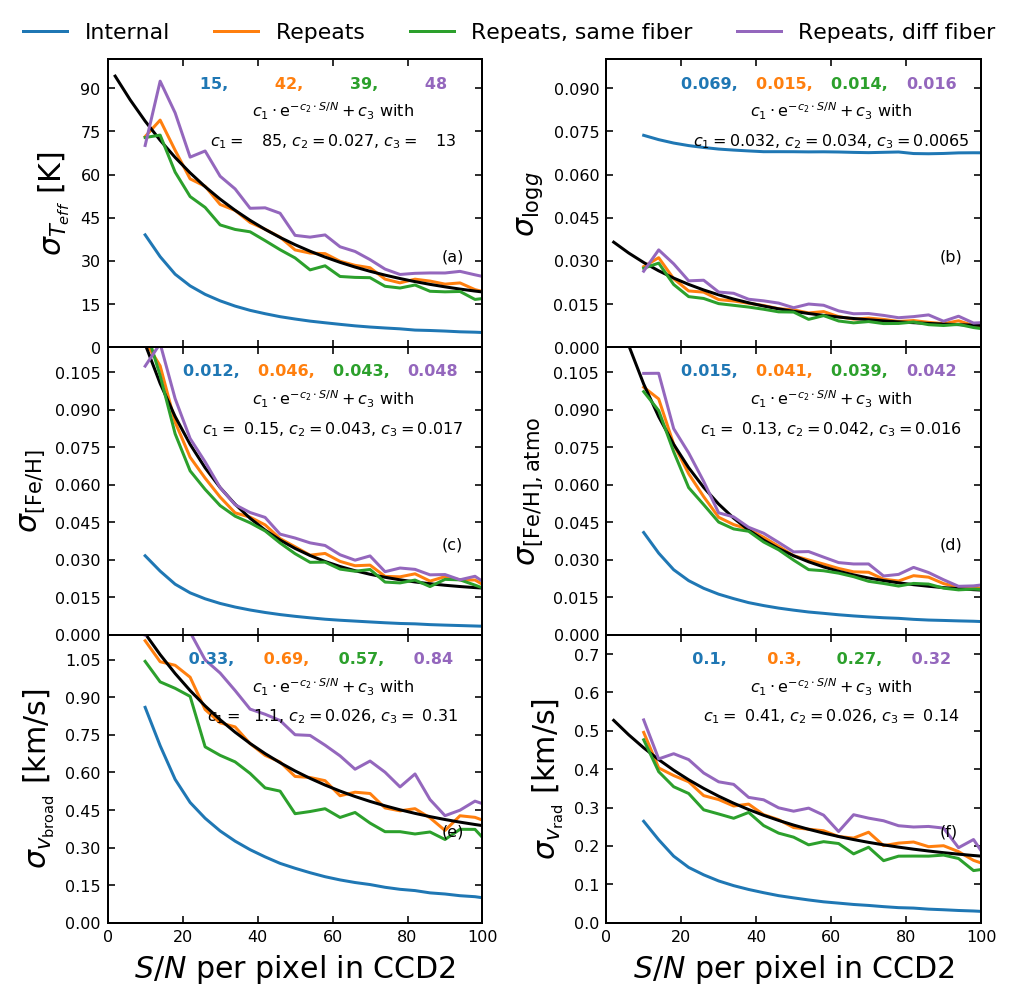

In [36]:
def plot_stellar_parameter_repeat_uncertainty(scaling_factor=1): 
    snr_med=40.
    plm=Plm2(3,2,ysize=7.0,xmulti=True,slabely=0.3,full=True)
    ylabel=[r'$\sigma_{T_{eff}}$ [K]',r'$\sigma_{\log g}$',r'$\sigma_{\rm [Fe/H]}$',r'$\sigma_{\rm [Fe/H],atmo}$', r'$\sigma_{v_{\rm broad}}$ [km/s]', r'$\sigma_{v_{\rm rad}}$ [km/s]']
    if quality_flag == 0:
        yrange=[100,0.1,0.115,0.115,1.15,0.75]
    else:
        yrange=[500,0.5,0.5,0.5,5,3.0]
    uncertainties = collections.OrderedDict()

    for i,key in enumerate(['teff','logg','fe_h','fe_h_atmo','vbroad','rv_galah']):
        plm.next()

        if i==0:
            label = 'Internal'
        else:
            label = '_nolegend_'
        if key not in ['logg','vmic']:
            ind1=np.where(np.isfinite(d['e_'+key]))[0]
            profile(d['snr_c2_iraf'][ind1],scaling_factor*d['cov_e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
            plt.axis([0,100,0,yrange[i]])
            plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1])),color='C0',fontweight='bold')
        if key == 'logg':
            ind1=np.where(np.isfinite(d['cov_e_'+key]))[0]
            profile(d['snr_c2_iraf'][ind1],d['cov_e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
            plt.axis([0,100,0,yrange[i]])
            plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1])),color='C0',fontweight='bold')
            
#         if i==0:
#             label = 'SME 536 / MC'
#         else:
#             label = '_nolegend_'
#         if key not in ['vmic']:
#             ind1=np.where(np.isfinite(d['e_'+key]))[0]
#             profile(d['snr_c2_iraf'][ind1],d['e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C1')
#             plt.axis([0,100,0,yrange[i]])
#             if key == 'teff':
#                 plm.text(0.4,0.9,'%5.3g, '%(np.median(d['e_'+key][ind1])),color='C1',fontweight='bold')
#             else:
#                 plm.text(0.4,0.9,'%5.2g, '%(np.median(d['e_'+key][ind1])),color='C1',fontweight='bold')

        plm.ylabel(ylabel[i], fontsize=15)
        plm.xlabel(r'$S/N$ per pixel in CCD2', fontsize=15)

        if i==0:
            label = 'Repeats'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr['e_'+key]))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
        ax=plt.gca()
        ax.plot(xm,ym,'C1-',label=label)
        plm.text(0.4,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C1',fontweight='bold')

        useful_xm_ym = np.isfinite(xm) & np.isfinite(ym) & (xm < 200)
        def snr_sigma_func(t, A, K, C):
            return np.abs(A) * np.exp(- K * t) + np.abs(C)
        opt_parms, parm_cov = scipy.optimize.curve_fit(snr_sigma_func, xm[useful_xm_ym], ym[useful_xm_ym], p0=[np.nanmedian(ym),0.1,0])

        ax.plot(xm,snr_sigma_func(xm,*opt_parms),c='k')
        ax.text(0.6,0.8,r'$c_1 \cdot \mathrm{e}^{-c_2 \cdot {S/N}} + c_3$ with',transform=ax.transAxes,ha='center')
        ax.text(0.6,0.7,r'$c_1 = $'+'%5.2g'%(opt_parms[0])+r', $c_2 = $'+'%5.2g'%(opt_parms[1])+r', $c_3 = $'+'%5.2g'%(opt_parms[2]),transform=ax.transAxes,ha='center')
        
        np.save('../validation/reference_uncertainties/repeats_'+key+'.npy',np.array(opt_parms))
        
        
        
        repeats_same_fibre[key] = [xm, ym]
        
        if i==0:
            label = 'Repeats, same fiber'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==1))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
        ax=plt.gca()
        ax.plot(xm,ym,'C2-',label=label)

        repeats_same_fibre[key] = [xm, ym]
        
        if i==0:
            label = 'Repeats, diff fiber'
        else:
            label = '_nolegend_'

        plm.text(0.6,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C2',fontweight='bold')
        ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==0))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C3')
        ax=plt.gca()
        ax.plot(xm,ym,'C4-',label=label)
        plm.text(0.8,0.9,'%5.2g'%(np.interp(snr_med,xm,ym)),color='C4',fontweight='bold')

        repeats_diff_fibre[key] = [xm, ym]

    plm.tight_layout()
    plm.legend(ncol=4, fontsize=11)

    plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'.pdf')
    plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'.png',dpi=300)

plot_stellar_parameter_repeat_uncertainty()

In [37]:
len(np.where(np.isfinite(dr['teff']))[0])/4

10029.5

In [38]:
# fe_h_step = 1.0
# fe_h_start = np.arange(-3,0.5,fe_h_step)
# fe_h_stop = np.arange(-3,0.5,fe_h_step)+fe_h_step

fe_h_start = [-4.00, -0.45, -0.25, -0.125, 0.025]
fe_h_stop  = [-0.45, -0.25, -0.125, 0.025, 1.00]

for each_fe_h_start,each_fe_h_stop in zip(fe_h_start,fe_h_stop):
    print(each_fe_h_start,each_fe_h_stop,len(np.where(np.isfinite(dr['e_teff']) & (dr['fe_h'] > each_fe_h_start) & (dr['fe_h'] <= each_fe_h_stop))[0]))

-4.0 -0.45 7135
-0.45 -0.25 8333
-0.25 -0.125 7293
-0.125 0.025 8937
0.025 1.0 8420


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp


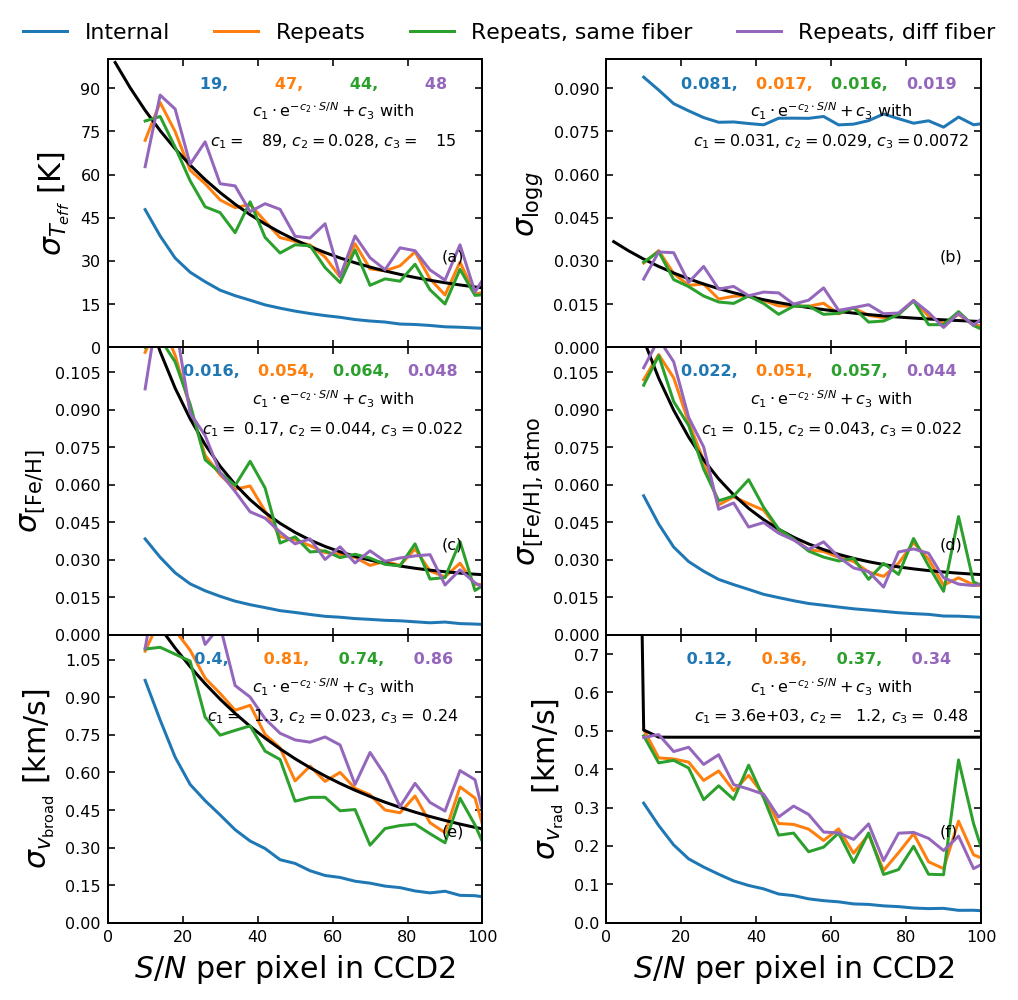

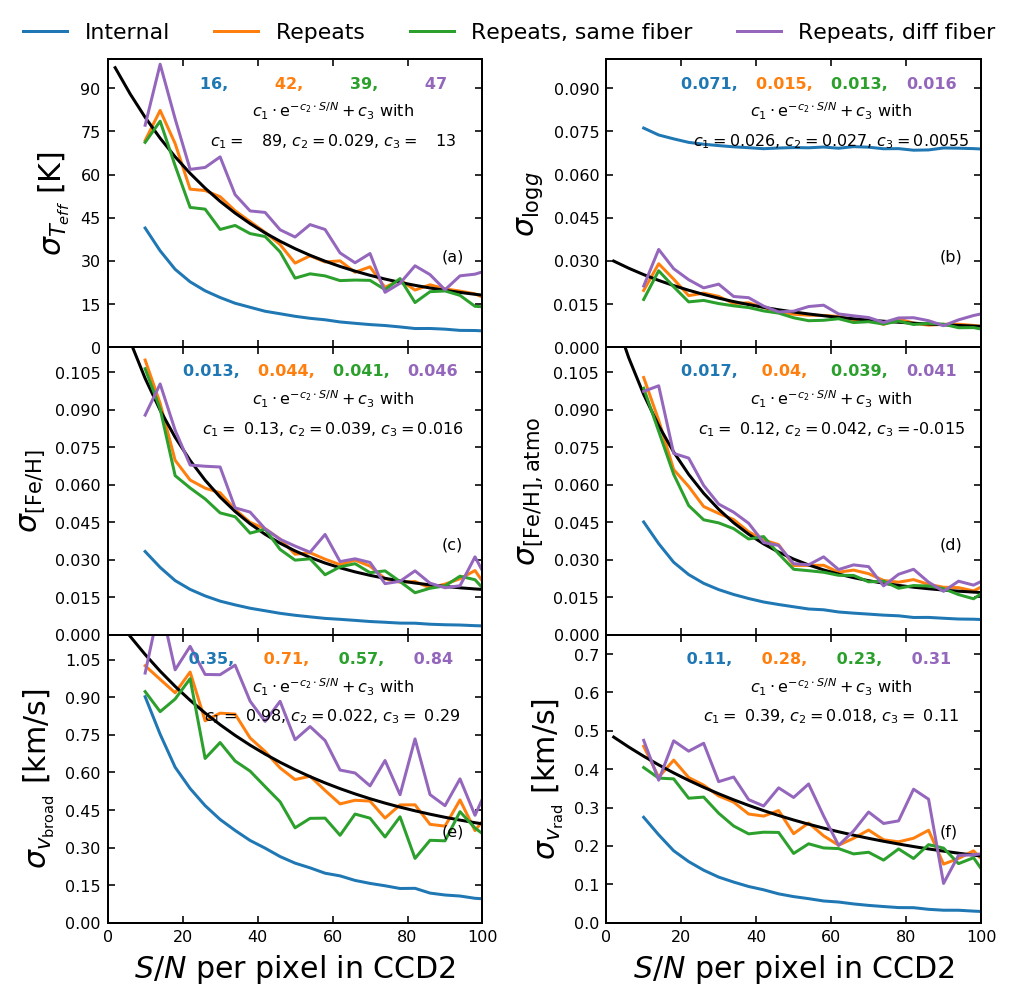

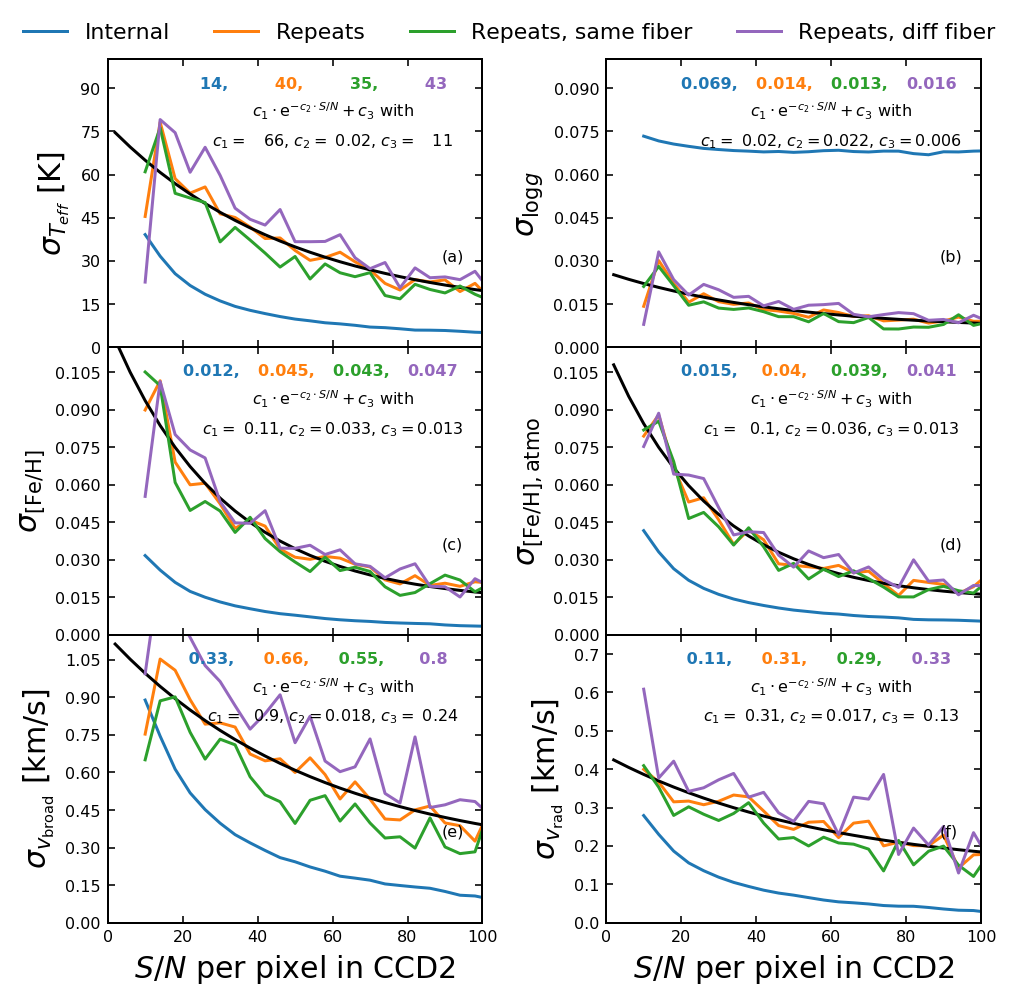

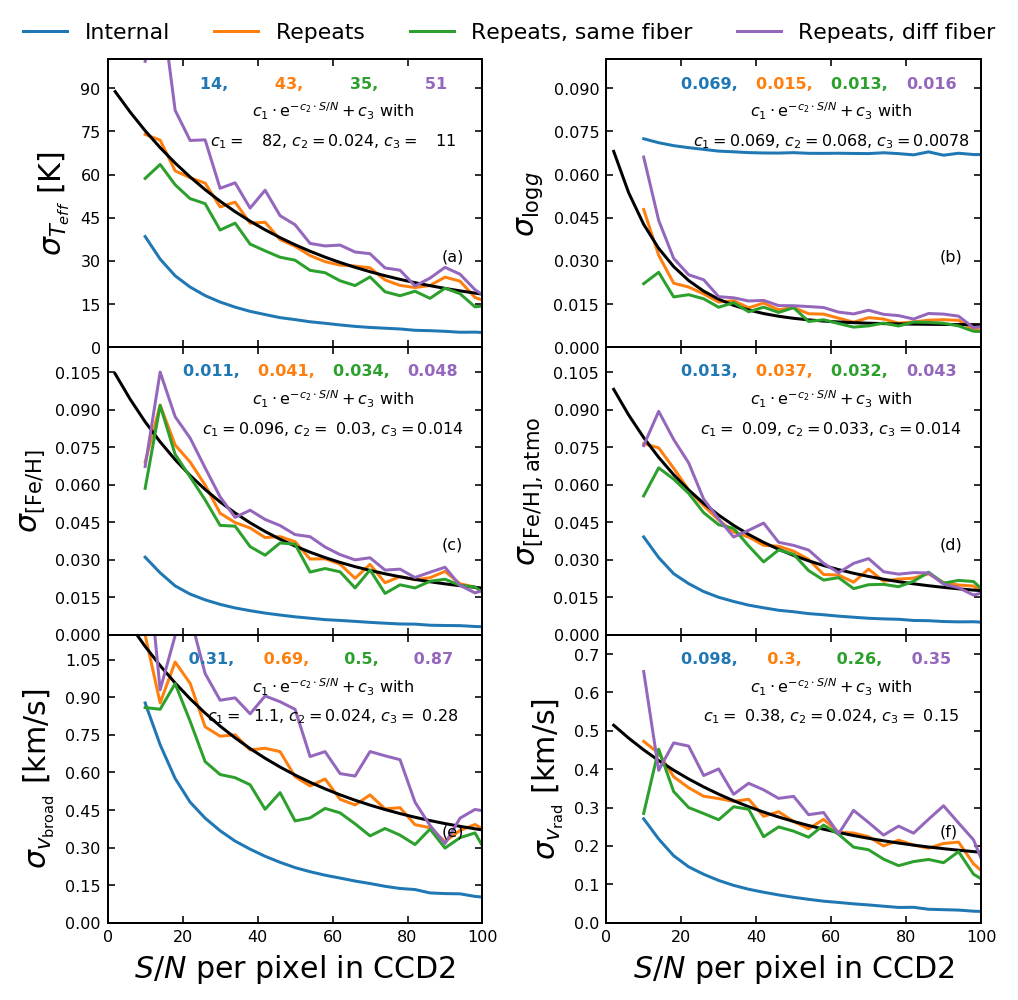

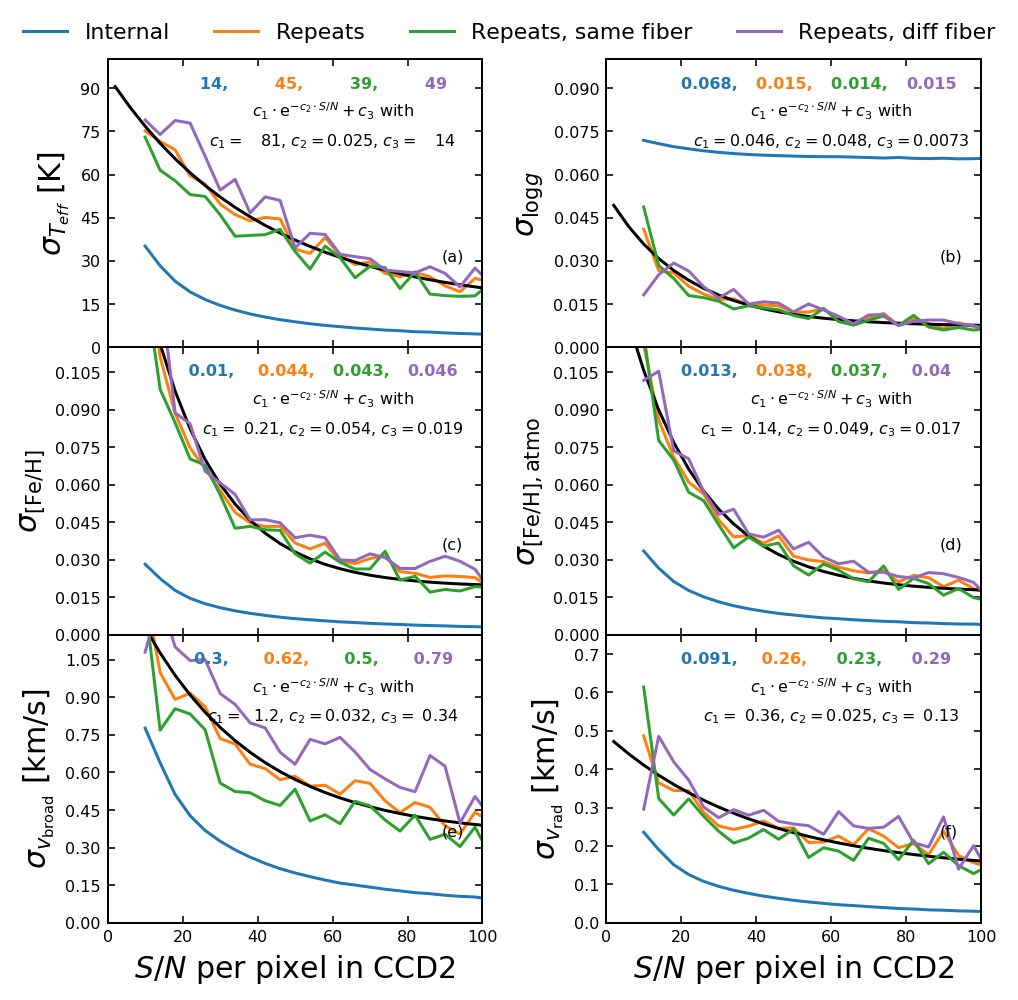

In [39]:
def plot_stellar_parameter_repeat_uncertainty_subset(scaling_factor=1): 
    
    for each_fe_h_start,each_fe_h_stop in zip(fe_h_start,fe_h_stop):
        
        snr_med=40.
        plm=Plm2(3,2,ysize=7.0,xmulti=True,slabely=0.3,full=True)
        ylabel=[r'$\sigma_{T_{eff}}$ [K]',r'$\sigma_{\log g}$',r'$\sigma_{\rm [Fe/H]}$',r'$\sigma_{\rm [Fe/H],atmo}$', r'$\sigma_{v_{\rm broad}}$ [km/s]', r'$\sigma_{v_{\rm rad}}$ [km/s]']
        if quality_flag == 0:
            yrange=[100,0.1,0.115,0.115,1.15,0.75]
        else:
            yrange=[500,0.5,0.5,0.5,5,3.0]
        uncertainties = collections.OrderedDict()

        for i,key in enumerate(['teff','logg','fe_h','fe_h_atmo','vbroad','rv_galah']):
            plm.next()

            if i==0:
                label = 'Internal'
            else:
                label = '_nolegend_'
            if key not in ['logg','vmic']:
                ind1=np.where(np.isfinite(d['e_'+key]) & (d['fe_h'] > each_fe_h_start) & (d['fe_h'] <= each_fe_h_stop))[0]
                profile(d['snr_c2_iraf'][ind1],scaling_factor*d['cov_e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
                plt.axis([0,100,0,yrange[i]])
                plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1])),color='C0',fontweight='bold')
            if key == 'logg':
                ind1=np.where(np.isfinite(d['cov_e_'+key]) & (d['fe_h'] > each_fe_h_start) & (d['fe_h'] <= each_fe_h_stop))[0]
                profile(d['snr_c2_iraf'][ind1],d['cov_e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
                plt.axis([0,100,0,yrange[i]])
                plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1])),color='C0',fontweight='bold')

    #         if i==0:
    #             label = 'SME 536 / MC'
    #         else:
    #             label = '_nolegend_'
    #         if key not in ['vmic']:
    #             ind1=np.where(np.isfinite(d['e_'+key]))[0]
    #             profile(d['snr_c2_iraf'][ind1],d['e_'+key][ind1],style='',label=label,range=[0,400],fmt='-',color='C1')
    #             plt.axis([0,100,0,yrange[i]])
    #             if key == 'teff':
    #                 plm.text(0.4,0.9,'%5.3g, '%(np.median(d['e_'+key][ind1])),color='C1',fontweight='bold')
    #             else:
    #                 plm.text(0.4,0.9,'%5.2g, '%(np.median(d['e_'+key][ind1])),color='C1',fontweight='bold')

            plm.ylabel(ylabel[i], fontsize=15)
            plm.xlabel(r'$S/N$ per pixel in CCD2', fontsize=15)

            if i==0:
                label = 'Repeats'
            else:
                label = '_nolegend_'

            ind=np.where(np.isfinite(dr['e_'+key]) & (dr['fe_h'] > each_fe_h_start) & (dr['fe_h'] <= each_fe_h_stop))[0]
            xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
            ax=plt.gca()
            ax.plot(xm,ym,'C1-',label=label)
            plm.text(0.4,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C1',fontweight='bold')

            useful_xm_ym = np.isfinite(xm) & np.isfinite(ym) & (xm < 200)
            def snr_sigma_func(t, A, K, C):
                return np.abs(A) * np.exp(- K * t) + np.abs(C)
            opt_parms, parm_cov = scipy.optimize.curve_fit(snr_sigma_func, xm[useful_xm_ym], ym[useful_xm_ym], p0=[np.nanmedian(ym),0.1,0])

            ax.plot(xm,snr_sigma_func(xm,*opt_parms),c='k')
            ax.text(0.6,0.8,r'$c_1 \cdot \mathrm{e}^{-c_2 \cdot {S/N}} + c_3$ with',transform=ax.transAxes,ha='center')
            ax.text(0.6,0.7,r'$c_1 = $'+'%5.2g'%(opt_parms[0])+r', $c_2 = $'+'%5.2g'%(opt_parms[1])+r', $c_3 = $'+'%5.2g'%(opt_parms[2]),transform=ax.transAxes,ha='center')


            repeats_same_fibre[key] = [xm, ym]

            if i==0:
                label = 'Repeats, same fiber'
            else:
                label = '_nolegend_'

            ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==1) & (dr['fe_h'] > each_fe_h_start) & (dr['fe_h'] <= each_fe_h_stop))[0]
            xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
            ax=plt.gca()
            ax.plot(xm,ym,'C2-',label=label)

            repeats_same_fibre[key] = [xm, ym]

            if i==0:
                label = 'Repeats, diff fiber'
            else:
                label = '_nolegend_'

            plm.text(0.6,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C2',fontweight='bold')
            ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==0) & (dr[r'fe_h'] > each_fe_h_start) & (dr['fe_h'] <= each_fe_h_stop))[0]
            xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C3')
            ax=plt.gca()
            ax.plot(xm,ym,'C4-',label=label)
            plm.text(0.8,0.9,'%5.2g'%(np.interp(snr_med,xm,ym)),color='C4',fontweight='bold')

            repeats_diff_fibre[key] = [xm, ym]

        plm.tight_layout()
        plm.legend(ncol=4, fontsize=11)

    #     plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'.pdf')
    #     plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'.png',dpi=300)

plot_stellar_parameter_repeat_uncertainty_subset()

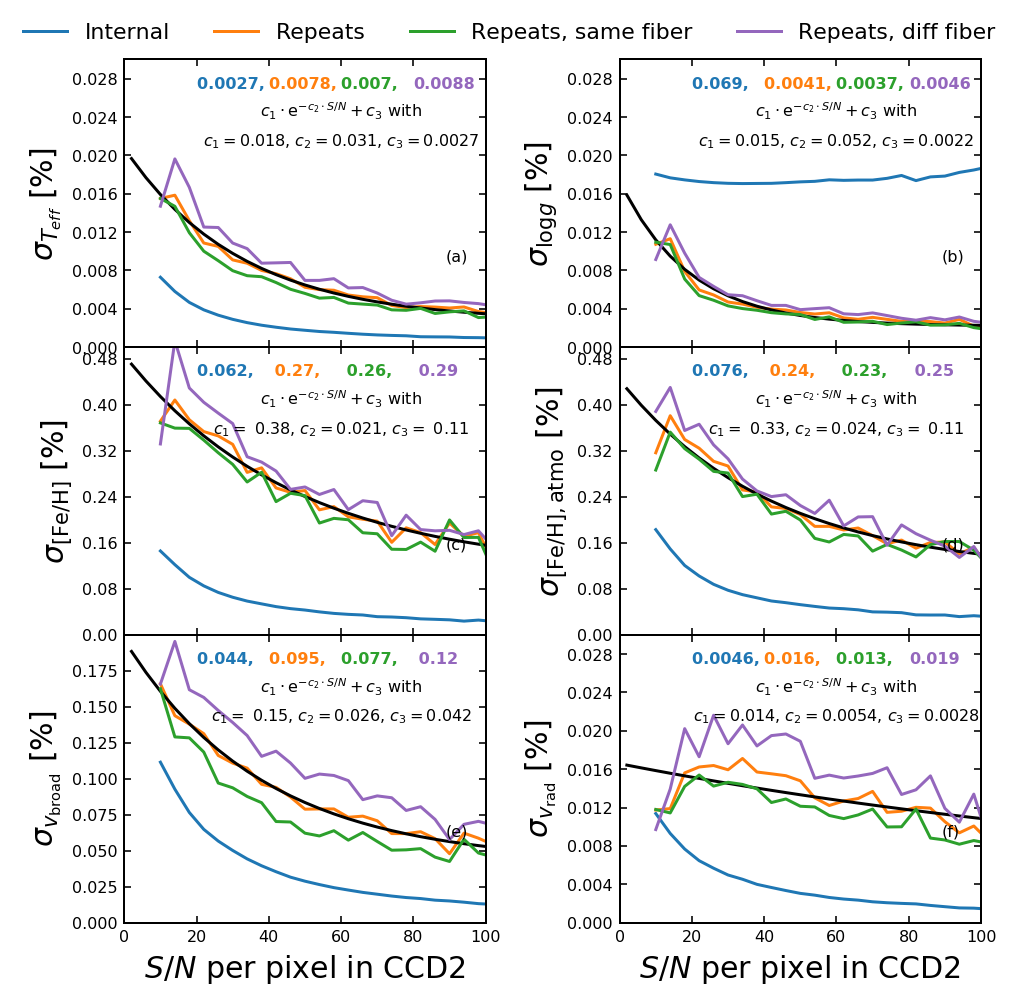

In [40]:
def plot_stellar_parameter_repeat_uncertainty_relative(scaling_factor=1): 
    snr_med=40.
    plm=Plm2(3,2,ysize=7.0,xmulti=True,slabely=0.3,full=True)
    ylabel=[r'$\sigma_{T_{eff}}$ [%]',r'$\sigma_{\log g}$ [%]',r'$\sigma_{\rm [Fe/H]}$ [%]',r'$\sigma_{\rm [Fe/H],atmo}$ [%]', r'$\sigma_{v_{\rm broad}}$ [%]', r'$\sigma_{v_{\rm rad}}$ [%]']
    if quality_flag == 0:
        yrange=[0.03,0.03,0.5,0.5,0.2,0.03]
    else:
        yrange=[500,0.5,0.5,0.5,5,3.0]
    uncertainties = collections.OrderedDict()

    for i,key in enumerate(['teff','logg','fe_h','fe_h_atmo','vbroad','rv_galah']):
        plm.next()

        if i==0:
            label = 'Internal'
        else:
            label = '_nolegend_'
        if key not in ['logg','vmic']:
            ind1=np.where(np.isfinite(d['e_'+key]))[0]
            profile(d['snr_c2_iraf'][ind1],scaling_factor*d['cov_e_'+key][ind1]/np.abs(d[key][ind1]),style='',label=label,range=[0,400],fmt='-',color='C0')
            plt.axis([0,100,0,yrange[i]])
            plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1]/np.abs(d[key][ind1]))),color='C0',fontweight='bold')
        if key == 'logg':
            ind1=np.where(np.isfinite(d['cov_e_'+key]))[0]
            profile(d['snr_c2_iraf'][ind1],d['cov_e_'+key][ind1]/np.abs(d[key][ind1]),style='',label=label,range=[0,400],fmt='-',color='C0')
            plt.axis([0,100,0,yrange[i]])
            plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d['cov_e_'+key][ind1])),color='C0',fontweight='bold')

        plm.ylabel(ylabel[i], fontsize=15)
        plm.xlabel(r'$S/N$ per pixel in CCD2', fontsize=15)

        if i==0:
            label = 'Repeats'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr['e_'+key]))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind]/np.abs(dr[key][ind]),style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
        ax=plt.gca()
        ax.plot(xm,ym,'C1-',label=label)
        plm.text(0.4,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C1',fontweight='bold')

        useful_xm_ym = np.isfinite(xm) & np.isfinite(ym) & (xm < 200)
        def snr_sigma_func(t, A, K, C):
            return np.abs(A) * np.exp(- K * t) + np.abs(C)
        opt_parms, parm_cov = scipy.optimize.curve_fit(snr_sigma_func, xm[useful_xm_ym], ym[useful_xm_ym], p0=[np.nanmedian(ym),0.1,0])

        ax.plot(xm,snr_sigma_func(xm,*opt_parms),c='k')
        ax.text(0.6,0.8,r'$c_1 \cdot \mathrm{e}^{-c_2 \cdot {S/N}} + c_3$ with',transform=ax.transAxes,ha='center')
        ax.text(0.6,0.7,r'$c_1 = $'+'%5.2g'%(opt_parms[0])+r', $c_2 = $'+'%5.2g'%(opt_parms[1])+r', $c_3 = $'+'%5.2g'%(opt_parms[2]),transform=ax.transAxes,ha='center')
        
        np.save('../validation/reference_uncertainties/repeats_'+key+'_relative.npy',np.array(opt_parms))
        
        
        
        repeats_same_fibre[key] = [xm, ym]
        
        if i==0:
            label = 'Repeats, same fiber'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==1))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind]/np.abs(dr[key][ind]),style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
        ax=plt.gca()
        ax.plot(xm,ym,'C2-',label=label)

        repeats_same_fibre[key] = [xm, ym]
        
        if i==0:
            label = 'Repeats, diff fiber'
        else:
            label = '_nolegend_'

        plm.text(0.6,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C2',fontweight='bold')
        ind=np.where(np.isfinite(dr['e_'+key])&(dr['same_cfg']==0))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr['e_'+key][ind]/np.abs(dr[key][ind]),style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C3')
        ax=plt.gca()
        ax.plot(xm,ym,'C4-',label=label)
        plm.text(0.8,0.9,'%5.2g'%(np.interp(snr_med,xm,ym)),color='C4',fontweight='bold')

        repeats_diff_fibre[key] = [xm, ym]

    plm.tight_layout()
    plm.legend(ncol=4, fontsize=11)

    plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'_relative.pdf')
    plt.savefig('../figures/repeat_uncertainties_snr_flag'+str(quality_flag)+'_relative.png',dpi=300)

plot_stellar_parameter_repeat_uncertainty_relative()

In [41]:
single_lines = []
for each in data.keys():
    if (each[-3:] == '_fe') & (each[:2] not in ['e_','nr']):
        if each[:2] != 'Fe':
            if each not in [
                'flag_alpha_fe','e_alpha_fe','alpha_fe_fe','cov_e_alpha_fe','nr_alpha_fe','cov_e_alpha_fe_fe',
                'Li6708_NoRV_fe',
                #'Sc5657_fe','Sc5669_fe',
                'Ti6599_fe',
                #'V4747_fe','Cr4848_fe','Zr5681_fe','Mo5858_fe','Mo5751_fe','Mo6619_fe','Ru4869_fe','Sm4854_fe','CrII_fe',
                #'Co7713_fe'
                'Sm4792_fe',
                'LiI_fe',
                'CI_fe', 'OI_fe', 'NaI_fe', 'MgI_fe', 'AlI_fe', 'SiI_fe', 'KI_fe', 'CaI_fe', 'ScI_fe', 'ScII_fe',
                'TiI_fe', 'TiII_fe', 'VI_fe', 'CrI_fe', 'CrII_fe', 'MnI_fe', 'CoI_fe', 'NiI_fe', 'CuI_fe',
                'ZnI_fe', 'RbI_fe', 'SrI_fe', 'YII_fe', 'ZrI_fe', 'MoI_fe', 'RuI_fe', 'BaII_fe', 'LaII_fe',
                'CeII_fe', 'NdII_fe', 'SmII_fe', 'EuII_fe'
            ]:
                if each[:4]!='flag':
                    if each == 'alpha':
                        single_lines.append(each)
                    else:
                        single_lines.append(each[:-3])
single_lines = np.array(single_lines)
single_lines

array(['alpha', 'Li6708', 'C6588', 'O', 'Na', 'Mg5711', 'Al', 'Si',
       'K7699', 'Ca', 'Sc', 'Ti4758', 'Ti4759', 'Ti4778', 'Ti4782',
       'Ti4798', 'Ti4802', 'Ti4820', 'Ti5689', 'Ti5716', 'Ti5720',
       'Ti5739', 'Ti5866', 'Ti6717', 'Ti7853', 'Ti4720', 'Ti4765',
       'Ti4799', 'Ti4849', 'Ti4866', 'Ti4874', 'V4832', 'V4784', 'V4797',
       'Cr', 'Mn', 'Co4781', 'Co4900', 'Co5647', 'Co6490', 'Co6551',
       'Co6632', 'Co6679', 'Co7713', 'Co7838', 'Ni5847', 'Ni6586',
       'Cu5700', 'Cu5782', 'Zn4722', 'Zn4811', 'Rb7800', 'Sr6550', 'Y',
       'Y4820', 'Y4855', 'Y4884', 'Y5663', 'Y5729', 'Zr4739', 'Zr4772',
       'Zr4806', 'Zr4828', 'Zr5681', 'Mo5689', 'Mo5751', 'Mo5858',
       'Mo6619', 'Ru4758', 'Ru4869', 'Ru5699', 'Ba', 'La4716', 'La4749',
       'La4804', 'La5806', 'Ce4774', 'Nd4811', 'Nd5741', 'Nd5770',
       'Nd5812', 'Nd5842', 'Sm4720', 'Sm4837', 'Sm4848', 'Sm4854',
       'Eu5819', 'Eu6645'], dtype='<U6')

In [42]:
# def plot_abundance_repeat_uncertainty_thesis(elements = ['Cu5782','Ni5847','Eu6645'], post_may2019=True): 
#     snr_med=40.
#     plm=Plm2(4,2,ysize=7.0,xmulti=True,slabely=0.3,full=True)

#     for i,key in enumerate(elements):
#         plm.next()
        
#         if key in ['MgI']:
#             ylabel = r'['+key+'/Fe]'
#             yrange = 0.125
#         else:
#             ylabel = r'['+key+'/Fe]'
#             yrange = 0.125
            
        
#         if post_may2019==True:
#             if key in ['alpha','LiI', 'CI', 'OI',
#                        'NaI', 'MgI', 'AlI', 'SiI', 'KI', 'CaI', 'ScI', 'ScII', 'TiI',
#                        'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI', 'CuI', 'ZnI',
#                        'RbI', 'SrI', 'YII', 'ZrI', 'MoI', 'RuI', 'BaII', 'LaII', 'CeII',
#                        'NdII', 'SmII', 'EuII']:
#                 dr_error = 'e_'+key+'_fe'
#                 d_error = 'e_'+key+'_fe'
#             else:
#                 dr_error = 'e_'+key+'_fe'
#                 d_error = 'cov_e_'+key
#         else:
#             dr_error = 'e_'+key+'_fe'
#             d_error = 'e_'+key


            
#         if i==0:
#             label = 'Covariance'
#         else:
#             label = '_nolegend_'
#         if key not in ['logg','vmic']:
#             ind1=np.where(np.isfinite(d[d_error]))[0]
#             print(key, len(ind1))
#             profile(d['snr_c2_iraf'][ind1],d[d_error][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
#             plt.axis([0,100,0,yrange])
#             plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d[d_error][ind1])),color='C0',fontweight='bold')
#         plm.ylabel(ylabel, fontsize=15)
#         plm.xlabel('$S/N$ per pixel in CCD2', fontsize=15)

#         if i==0:
#             label = 'Repeats'
#         else:
#             label = '_nolegend_'

#         ind=np.where(np.isfinite(dr[dr_error]))[0]
#         xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C1')
#         ax=plt.gca()
#         ax.plot(xm,ym,'C1-',label=label)
#         plm.text(0.4,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C1',fontweight='bold')

#         repeats_same_fibre[key] = [xm, ym]

#         if i==0:
#             label = 'Repeats, same fiber'
#         else:
#             label = '_nolegend_'

#         ind=np.where(np.isfinite(dr[dr_error])&(dr['same_cfg']==1))[0]
#         xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
#         ax=plt.gca()
#         ax.plot(xm,ym,'C2-',label=label)
#         plm.text(0.6,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C2',fontweight='bold')

#         repeats_same_fibre[key] = [xm, ym]

#         if i==0:
#             label = 'Repeats, diff fiber'
#         else:
#             label = '_nolegend_'

#         ind=np.where(np.isfinite(dr[dr_error])&(dr['same_cfg']==0))[0]
#         xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C4')
#         ax=plt.gca()
#         ax.plot(xm,ym,'C4-',label=label)
#         plm.text(0.8,0.9,'%5.2g'%(np.interp(snr_med,xm,ym)),color='C4',fontweight='bold')

#         repeats_diff_fibre[key] = [xm, ym]

#     plm.tight_layout()
#     plm.legend(ncol=4, fontsize=12)

#     plt.savefig('../figures/repeat_uncertainties_silicon.pdf', dpi=300, bbox_inches='tight')
#     plt.savefig('../figures/repeat_uncertainties_silicon.png', dpi=200, bbox_inches='tight')

# plot_abundance_repeat_uncertainty_thesis(elements = ['alpha','SiI','Si5684', 'Si5690',
#         'Si5772', 'Si5793', 'Si6722', 'Si7680'])

In [43]:
def plot_abundance_repeat_uncertainty_single(elements = ['Cu5782','Ni5847','Eu6645'], part=1, post_may2019=True): 
    snr_med=50.
    plm=Plm2(4,2,ysize=7.0,xmulti=True,slabely=0.3,full=True)

    for i,key in enumerate(elements):
        plm.next()
        
        ylabel = r'['+key+'/Fe]'
        yrange = 0.15
                
        if post_may2019==True:
            if key in ['alpha','LiI', 'CI', 'OI',
                       'NaI', 'MgI', 'AlI', 'SiI', 'KI', 'CaI', 'ScI', 'ScII', 'TiI',
                       'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI', 'CuI', 'ZnI',
                       'RbI', 'SrI', 'YII', 'ZrI', 'MoI', 'RuI', 'BaII', 'LaII', 'CeII',
                       'NdII', 'SmII', 'EuII']:
                dr_error = 'e_'+key+'_fe'
                d_error = 'e_'+key+'_fe'
            else:
                dr_error = 'e_'+key+'_fe'
                d_error = 'cov_e_'+key
        else:
            dr_error = 'e_'+key+'_fe'
            d_error = 'e_'+key

        if i==0:
            label = 'Covariance'
        else:
            label = '_nolegend_'
        if key not in ['logg','vmic']:
            ind1=np.where(np.isfinite(d[d_error]))[0]
            print(key, len(ind1))
            profile(d['snr_c2_iraf'][ind1],d[d_error][ind1],style='',label=label,range=[0,400],fmt='-',color='C0')
            plt.axis([0,100,0,yrange])
            plm.text(0.2,0.9,'%5.2g, '%(np.nanmedian(d[d_error][ind1])),color='C0',fontweight='bold')
        plm.ylabel(ylabel, fontsize=15)
        plm.xlabel('$S/N$ per pixel in CCD2', fontsize=15)

        if i==0:
            label = 'Repeats'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr[dr_error]))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C1')
        ax=plt.gca()
        ax.plot(xm,ym,'C1-',label=label)
        plm.text(0.4,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C1',fontweight='bold')

        repeats_same_fibre[key] = [xm, ym]

        useful_xm_ym = np.isfinite(xm) & np.isfinite(ym) & (xm < 200)
        def snr_sigma_func(t, A, K, C):
            return np.abs(A) * np.exp(- K * t) + np.abs(C)
        opt_parms, parm_cov = scipy.optimize.curve_fit(snr_sigma_func, xm[useful_xm_ym], ym[useful_xm_ym], p0=[np.nanmedian(ym),0.1,0])

        ax.plot(xm,snr_sigma_func(xm,*opt_parms),c='k')
        ax.text(0.6,0.8,r'$c_1 \cdot \mathrm{e}^{-c_2 \cdot {S/N}} + c_3$ with',transform=ax.transAxes,ha='center')
        ax.text(0.6,0.7,r'$c_1 = $'+'%5.2g'%(opt_parms[0])+r', $c_2 = $'+'%5.2g'%(opt_parms[1])+r', $c_3 = $'+'%5.2g'%(opt_parms[2]),transform=ax.transAxes,ha='center')

        np.save('../validation/reference_uncertainties/repeats_'+key+'.npy',np.array(opt_parms))

        if i==0:
            label = 'Repeats, same fiber'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr[dr_error])&(dr['same_cfg']==1))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C2')
        ax=plt.gca()
        ax.plot(xm,ym,'C2-',label=label)
        plm.text(0.6,0.9,'%5.2g, '%(np.interp(snr_med,xm,ym)),color='C2',fontweight='bold')

        repeats_same_fibre[key] = [xm, ym]

        if i==0:
            label = 'Repeats, diff fiber'
        else:
            label = '_nolegend_'

        ind=np.where(np.isfinite(dr[dr_error])&(dr['same_cfg']==0))[0]
        xm,ym,hdata=profile(dr['snr_c2_iraf'][ind],dr[dr_error][ind],style='',func=std,label=label,range=[0,400],fmt='-',return_profile=True,color='C4')
        ax=plt.gca()
        ax.plot(xm,ym,'C4-',label=label)
        plm.text(0.8,0.9,'%5.2g'%(np.interp(snr_med,xm,ym)),color='C4',fontweight='bold')

        repeats_diff_fibre[key] = [xm, ym]

    plm.tight_layout()
    plm.legend(ncol=4, fontsize=12)

    plt.savefig('../figures/repeat_uncertainties_snr_single_'+str(part)+'.pdf')

['alpha' 'Li6708' 'C6588' 'O' 'Na' 'Mg5711' 'Al' 'Si']
alpha 404244
Li6708 415445
C6588 415445
O 415445
Na 415445
Mg5711 415445
Al 415445
Si 415445
['K7699' 'Ca' 'Sc' 'Ti4758' 'Ti4759' 'Ti4778' 'Ti4782' 'Ti4798']
K7699 415445
Ca 415445
Sc 415445
Ti4758 415445
Ti4759 415445
Ti4778 415445
Ti4782 415445


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


Ti4798 415445
['Ti4802' 'Ti4820' 'Ti5689' 'Ti5716' 'Ti5720' 'Ti5739' 'Ti5866' 'Ti6717']
Ti4802 415445


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


Ti4820 415445
Ti5689 415445
Ti5716 415445
Ti5720 415445
Ti5739 415445
Ti5866 415445
Ti6717 415445
['Ti7853' 'Ti4720' 'Ti4765' 'Ti4799' 'Ti4849' 'Ti4866' 'Ti4874' 'V4832']
Ti7853 415445
Ti4720 415445
Ti4765 415445
Ti4799 415445
Ti4849 415445
Ti4866 415445
Ti4874 415445


/Users/svenbuder/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


V4832 415445
['V4784' 'V4797' 'Cr' 'Mn' 'Co4781' 'Co4900' 'Co5647' 'Co6490']
V4784 415445


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

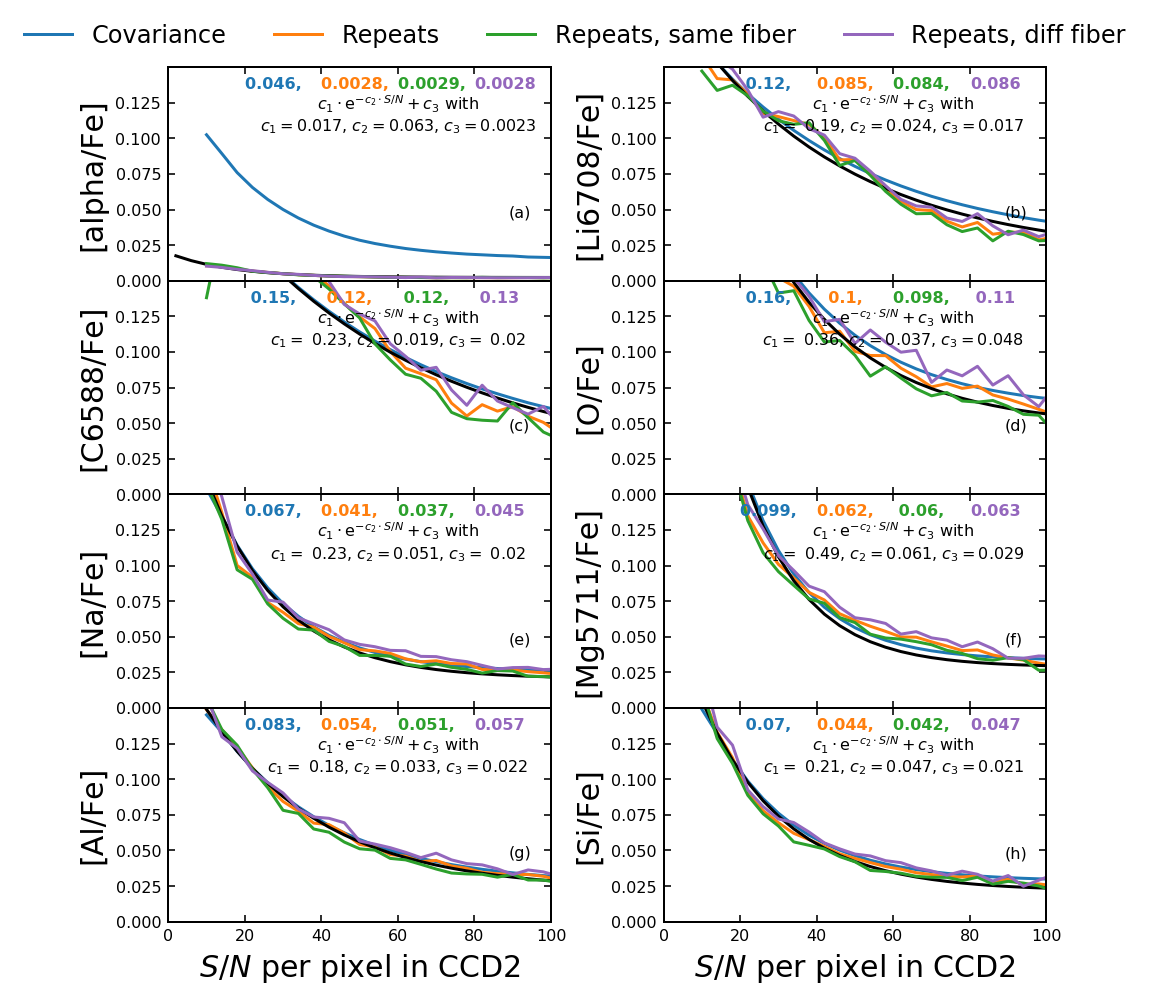

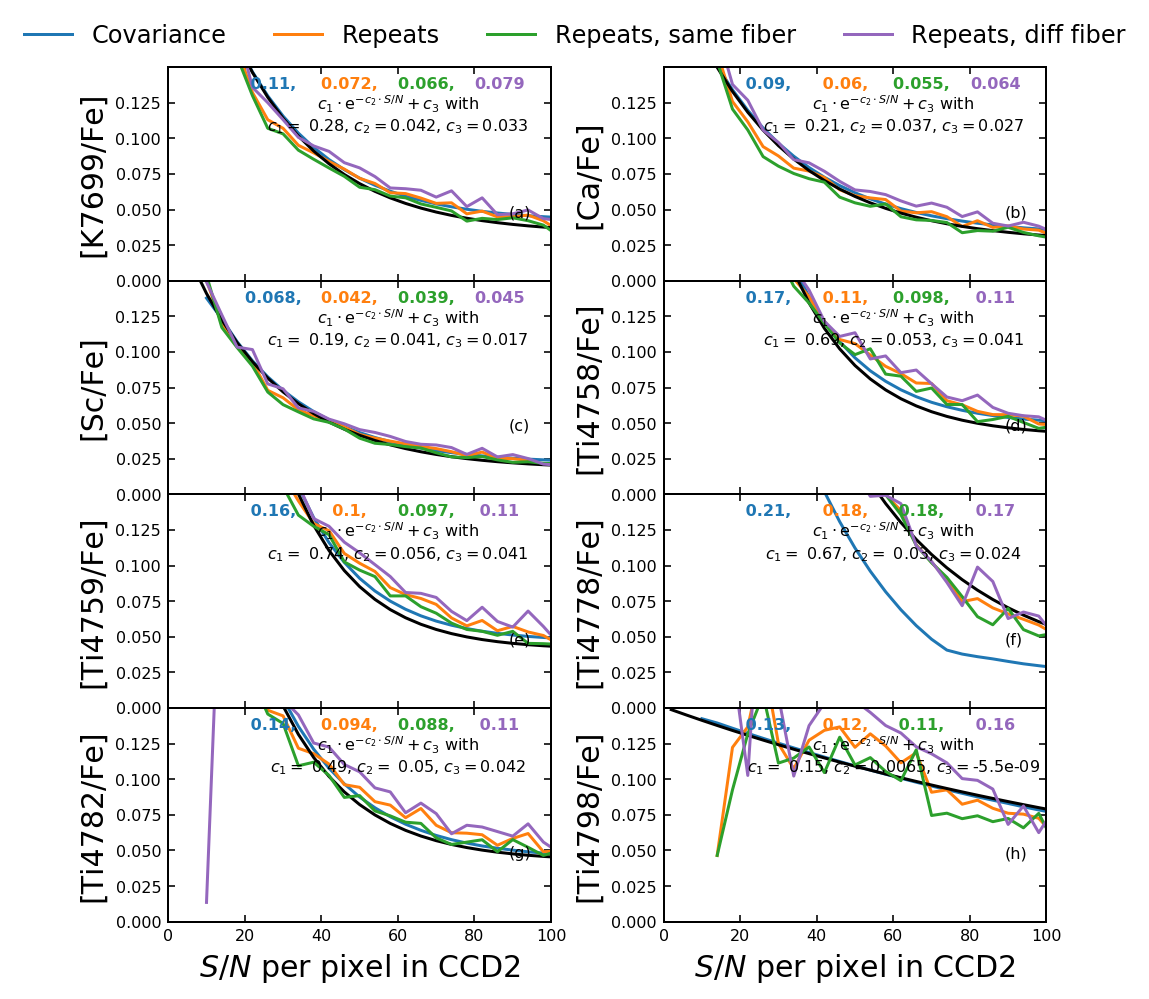

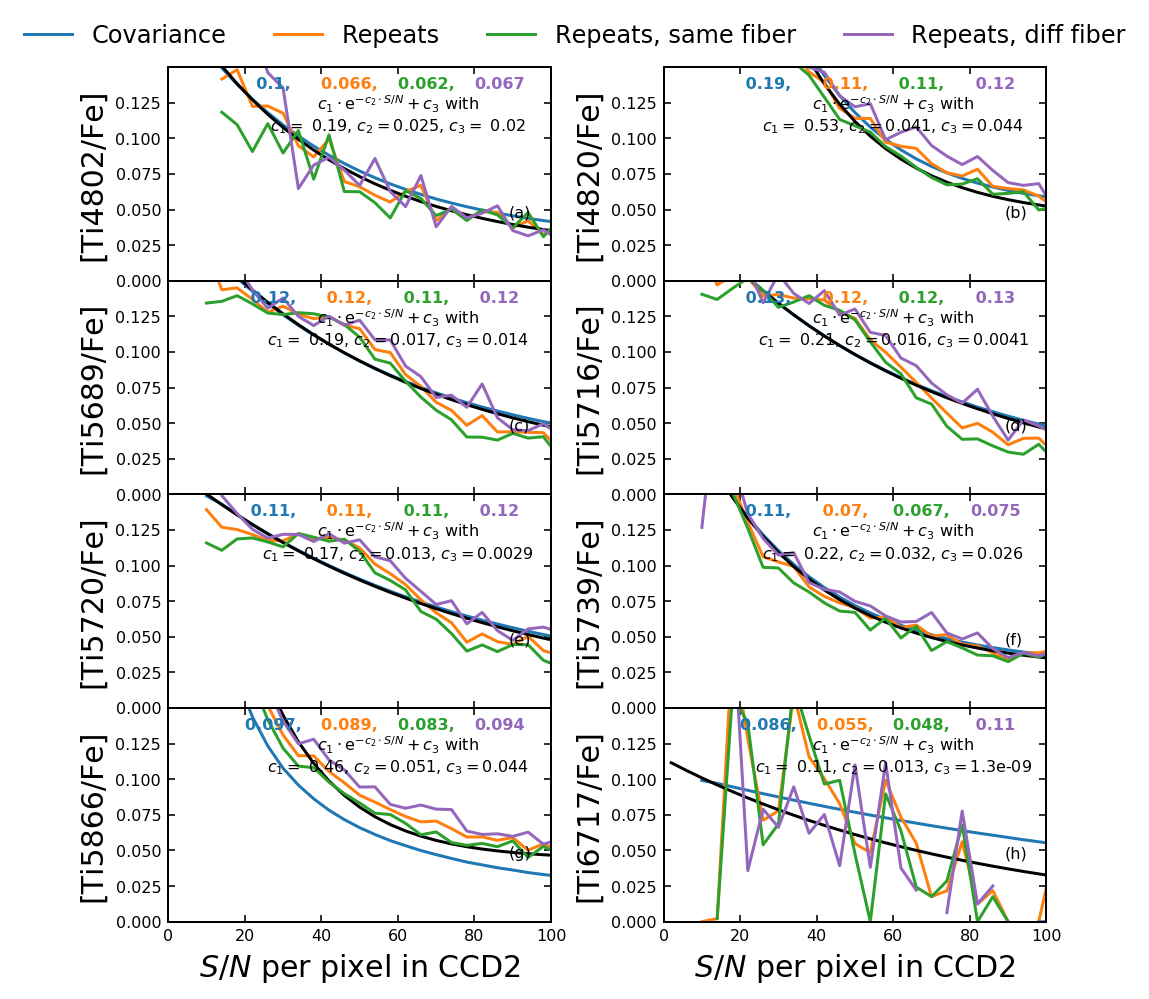

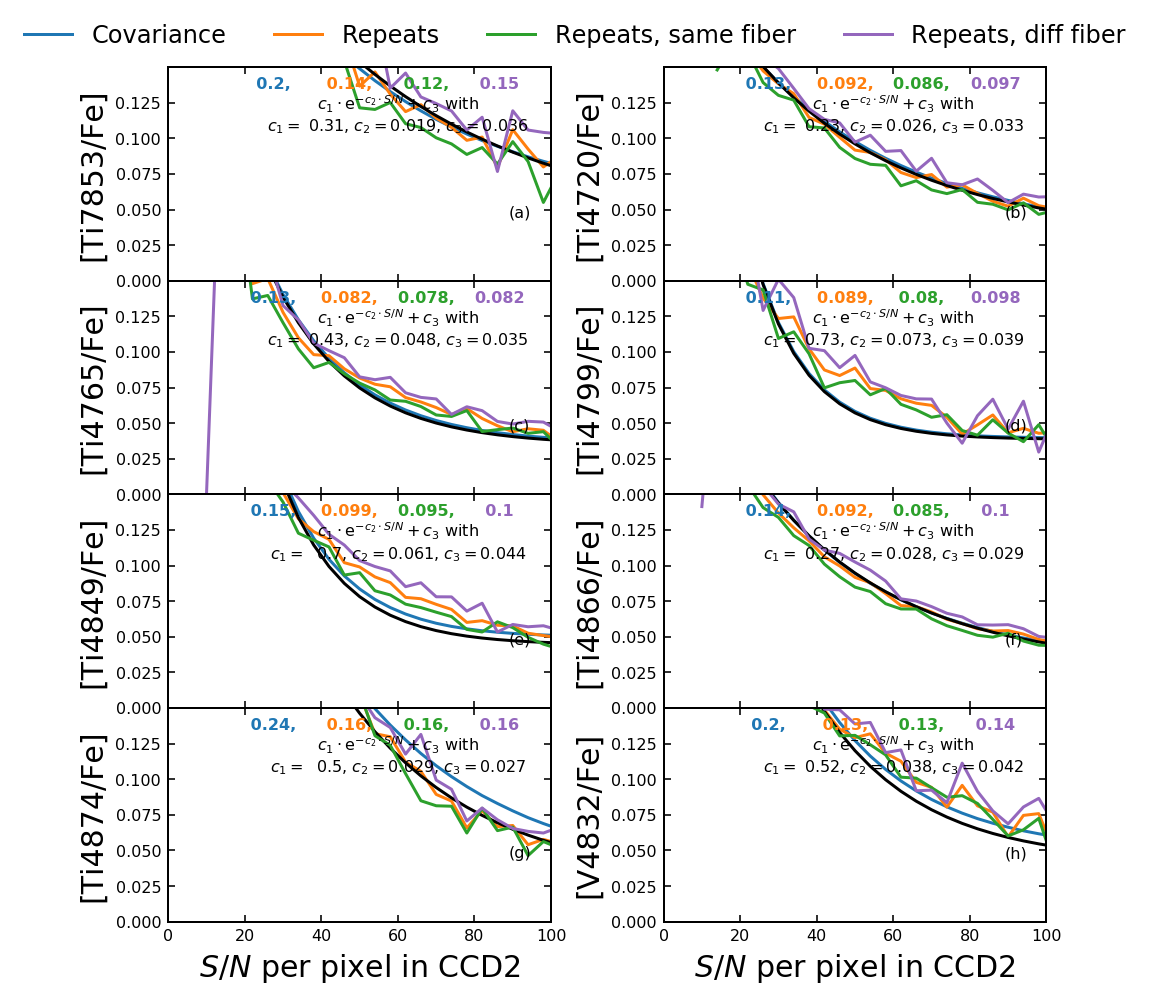

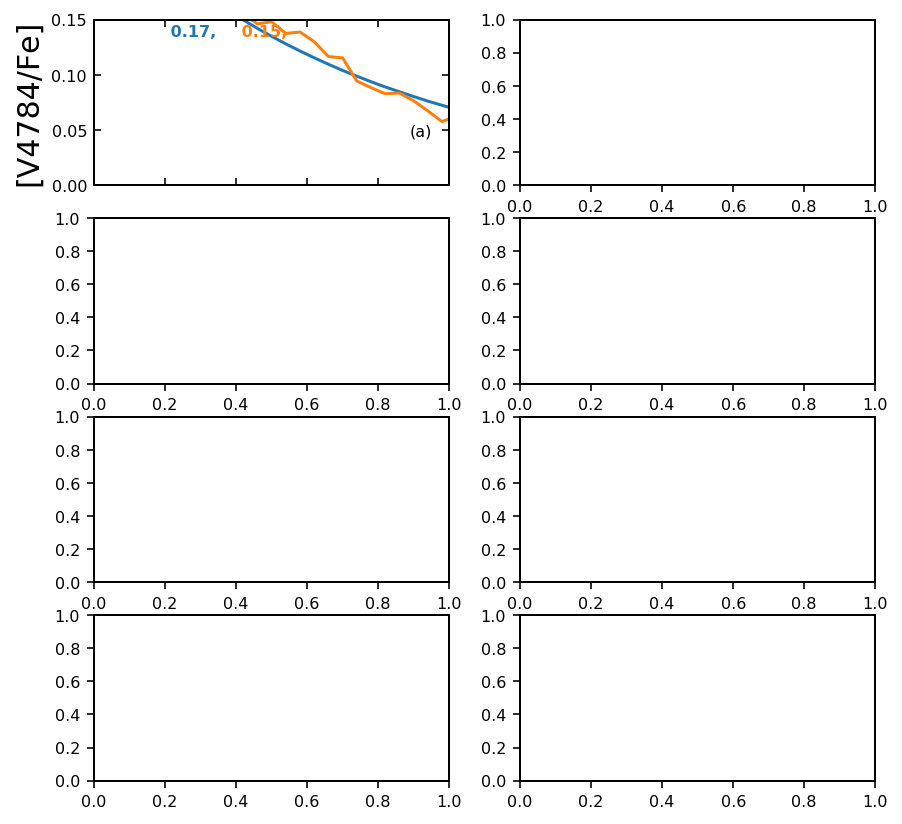

In [44]:
for each_bunch in range(int(round(len(single_lines)/8+0.5))):
    elements = single_lines[(each_bunch)*8:np.min([len(single_lines),(each_bunch+1)*8])]
    print(elements)

    plot_abundance_repeat_uncertainty_single(elements = elements, part=each_bunch)